In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
url = 'https://github.com/haphuong-ng/Hanoi-Hourly/raw/refs/heads/main/Hanoi%20Hourly.csv'
df_hourly = pd.read_csv(url)
df_hourly.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,Hanoi,2015-01-01T00:00:00,15.0,15.0,13.0,87.84,0.0,0,NaN,0.0,...,1023.0,0.0,3.5,0.0,0.0,0.0,NaN,Clear,clear-night,"48820099999,VVNB"
1,Hanoi,2015-01-01T01:00:00,15.8,15.8,13.0,83.33,0.0,0,NaN,0.0,...,1022.6,0.0,8.5,0.0,0.0,0.0,NaN,Clear,clear-night,"48820099999,48825099999,48831099999,VVNB"
2,Hanoi,2015-01-01T02:00:00,13.5,13.5,12.0,90.65,0.0,0,NaN,0.0,...,1022.0,0.0,3.0,0.0,0.0,0.0,NaN,Clear,clear-night,"48820099999,VVNB"
3,Hanoi,2015-01-01T03:00:00,13.0,13.0,12.0,93.65,0.0,0,NaN,0.0,...,1022.0,0.0,2.0,0.0,0.0,0.0,NaN,Clear,clear-night,VVNB
4,Hanoi,2015-01-01T04:00:00,14.7,14.7,12.5,86.57,0.0,0,NaN,0.0,...,1022.4,0.0,8.2,0.0,0.0,0.0,NaN,Clear,clear-night,"48820099999,48825099999,VVNB"


# **STEP 2: Data understanding**

## **Explain the meaning and values in each column**

| Feature | Description | Type |
|---|---|---|
| name | The name of the location (e.g., "Hanoi") | Categorical |
| datetime | The specific date and time of the weather observation | Datetime |
| temp | The recorded temperature (likely in Celsius) | Numerical |
| feelslike | The apparent temperature, what it "feels like" to a human (accounts for humidity, wind) | Numerical |
| dew | The dew point temperature (the temperature at which air becomes saturated) | Numerical |
| humidity | The relative humidity, expressed as a percentage | Numerical |
| precip | The amount of precipitation (e.g., rain, snow) recorded in the period | Numerical |
| precipprob | The probability of precipitation occurring, as a percentage | Numerical |
| preciptype | The type of precipitation (e.g., "rain", "snow", or null) | Categorical |
| snow | The amount of snowfall recorded | Numerical |
| snowdepth | The depth of accumulated snow on the ground | Numerical |
| windgust | The peak wind gust speed | Numerical |
| windspeed | The average wind speed | Numerical |
| winddir | The wind direction, in degrees (0-360) | Numerical |
| sealevelpressure | The atmospheric pressure adjusted to mean sea level (e.g., in mbar) | Numerical |
| cloudcover | The percentage of the sky covered by clouds | Numerical |
| visibility | The distance one can see (e.g., in kilometers) | Numerical |
| solarradiation | The amount of solar radiation received | Numerical |
| solarenergy | The total solar energy received over the period | Numerical |
| uvindex | The ultraviolet (UV) index rating | Numerical |
| severerisk | A rating of the risk for severe weather | Numerical |
| conditions | A text description of the overall weather conditions (e.g., "Rain, Partially cloudy") | Categorical |
| icon | A text key used to represent the weather icon (e.g., "rain", "clear-night") | Categorical |
| stations | The identifier(s) for the weather station(s) reporting the data | Categorical |

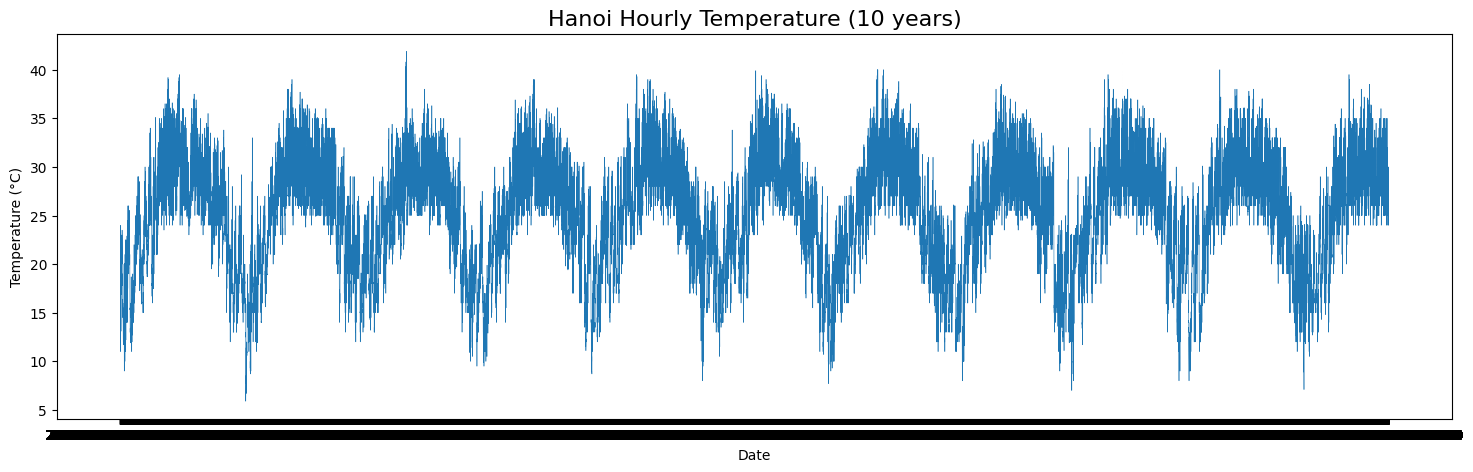

In [3]:
plt.figure(figsize=(18,5))
plt.plot(df_hourly['datetime'], df_hourly['temp'], linewidth=0.4)
plt.title("Hanoi Hourly Temperature (10 years)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

**Detailed Plot Interpretation**

The resulting line plot effectively visualizes 10 years of hourly temperature data for Hanoi. Here are the key observations:

**Key Patterns**

* **Dominant Annual Seasonality:** The most prominent feature is the clear, repeating cyclical pattern. This represents Hanoi's annual seasons.
    * **Summer (Hot Season):** The temperature peaks in the middle of each year (around June-August), consistently reaching highs between 35°C and 40°C.
    * **Winter (Cold Season):** The temperature reaches its minimum at the beginning and end of each year (around December-January), dropping to lows between 5°C and 10°C.
* **Diurnal (Daily) Cycle:** The plot does not show a single, smooth line. Instead, it appears as a thick, "fuzzy" band. This **density** is the visual representation of the **daily (diurnal) cycle**. The "thickness" of the band at any point in time shows the daily fluctuation—the temperature rising during the day and falling at night.
* **Amplitude of Fluctuation:** The "thickness" of this band (the daily fluctuation) appears wider during the winter months and narrower during the summer. This suggests that the temperature difference between day and night might be more significant during the cold season.

**Specific Observations**

* **Temperature Range:** The y-axis shows that temperatures in Hanoi over the last 10 years have ranged from a low of approximately 5°C to a high of around 40°C.
* **Extreme Events:**
    * **Cold Snaps:** There are several notable sharp dips during winter, particularly around 2016 and 2021, where the temperature plunged significantly, approaching the 5°C mark.
    * **Heat Waves:** The summer peaks are not uniform. Some years (like 2017, 2019, and 2025) show exceptionally sharp and high peaks, indicating periods of extreme heat.
* **Overall Trend:** Visually, there is no obvious, strong linear trend (i.e., it's not immediately obvious if the average temperature is rising or falling). The primary pattern is cyclical (seasonal). A more complex analysis (like a rolling average) would be needed to determine a subtle long-term climate trend.

In [4]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94248 entries, 0 to 94247
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              94248 non-null  object 
 1   datetime          94248 non-null  object 
 2   temp              94248 non-null  float64
 3   feelslike         94248 non-null  float64
 4   dew               94248 non-null  float64
 5   humidity          94248 non-null  float64
 6   precip            94209 non-null  float64
 7   precipprob        94248 non-null  int64  
 8   preciptype        12055 non-null  object 
 9   snow              94206 non-null  float64
 10  snowdepth         94206 non-null  float64
 11  windgust          94199 non-null  float64
 12  windspeed         94247 non-null  float64
 13  winddir           94246 non-null  float64
 14  sealevelpressure  94248 non-null  float64
 15  cloudcover        94248 non-null  float64
 16  visibility        94070 non-null  float6

In [5]:
df_hourly['datetime'] = pd.to_datetime(df_hourly['datetime'])

# **STEP 3: Data Processing**

## **Handle missing value**

In [6]:
missing_summary = pd.DataFrame({
    'missing_count': df_hourly.isnull().sum(),
    'missing_percent': df_hourly.isnull().mean() * 100
})

missing_summary

,missing_count,missing_percent
name,0,0.000000
datetime,0,0.000000
temp,0,0.000000
feelslike,0,0.000000
dew,0,0.000000
humidity,0,0.000000
precip,39,0.041380
precipprob,0,0.000000
preciptype,82193,87.209278
snow,42,0.044563


The resulting table, `missing_summary`, provides a clear quantitative assessment of data completeness across all features in the hourly dataset.

A group of features exhibits minor missingness such as `precip`, wind-related and solar-related fields. These variables are important for analysis and will be handled to preserve the maximum number of records.

### **`preciptype`, `severerisk`, `snow` and `snowdepth`**

In [7]:
df_hourly['snow'].value_counts(dropna=False)

snow
0.0    94206
NaN       42
Name: count, dtype: int64

In [8]:
df_hourly['snowdepth'].value_counts(dropna=False)

snowdepth
0.0    94206
NaN       42
Name: count, dtype: int64

Meanwhile, a distinct group of features will be dropped from the dataset for two primary reasons: geographic irrelevance and severe sparsity.
- Geographic irrelevance: The columns `snow` and `snowdepth` will be removed. Since the dataset pertains to Vietnam, which is a tropical and subtropical country where snowfall is virtually non-existent, these features are not relevant to the local context and do not contribute to meaningful weather modeling.
- Severe sparsity: The features `preciptype` (`82.2%` missing) and `severerisk` (`61.6%` missing) exhibit an extremely high percentage of missing values. Therefore, to maintain data quality and reliability, both of these highly sparse variables will also be dropped.

In [9]:
df_hourly.drop(columns=['severerisk', 'preciptype', 'snow', 'snowdepth'], inplace=True)

### **`precip`**

In [10]:
missing_precip = df_hourly[df_hourly['precip'].isnull()]
missing_precip

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,icon,stations
1541,Hanoi,2015-03-06 05:00:00,20.0,20.0,19.0,93.97,NaN,0,11.2,5.6,20.0,1012.0,89.0,4.0,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"
1542,Hanoi,2015-03-06 06:00:00,19.5,19.5,19.0,96.94,NaN,0,NaN,9.4,55.0,1013.0,89.0,2.5,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"
13424,Hanoi,2016-07-13 08:00:00,29.0,35.6,26.0,83.90,NaN,0,15.1,7.6,330.0,1002.0,89.0,9.0,NaN,NaN,NaN,Partially cloudy,partly-cloudy-day,"48820099999,VVNB"
13425,Hanoi,2016-07-13 09:00:00,30.0,37.4,26.0,79.20,NaN,0,16.2,5.4,340.0,1002.0,89.0,10.0,NaN,NaN,NaN,Partially cloudy,partly-cloudy-day,"48820099999,VVNB"
13427,Hanoi,2016-07-13 11:00:00,31.0,40.6,27.0,79.33,NaN,0,19.8,9.4,70.0,1002.0,89.0,5.0,NaN,NaN,NaN,Partially cloudy,partly-cloudy-day,"48820099999,VVNB"
13428,Hanoi,2016-07-13 12:00:00,31.0,40.6,27.0,79.33,NaN,0,20.5,13.0,80.0,1002.0,89.0,7.0,NaN,NaN,NaN,Partially cloudy,partly-cloudy-day,"48820099999,VVNB"
13430,Hanoi,2016-07-13 14:00:00,31.0,40.6,27.0,79.33,NaN,0,NaN,13.0,90.0,1001.0,89.0,8.0,NaN,NaN,NaN,Partially cloudy,partly-cloudy-day,"48820099999,VVNB"
13431,Hanoi,2016-07-13 15:00:00,31.4,40.8,26.8,76.63,NaN,0,NaN,NaN,NaN,999.0,99.9,NaN,NaN,NaN,NaN,Overcast,cloudy,remote
13433,Hanoi,2016-07-13 17:00:00,29.0,34.5,25.0,79.06,NaN,0,13.0,16.6,110.0,1000.0,89.0,10.0,NaN,NaN,NaN,Partially cloudy,partly-cloudy-day,"48820099999,VVNB"
13434,Hanoi,2016-07-13 18:00:00,29.0,34.5,25.0,79.06,NaN,0,15.1,16.6,100.0,1000.0,27.5,10.0,NaN,NaN,NaN,Partially cloudy,partly-cloudy-day,"48820099999,VVNB"


Based on the output above, we known that for all rows where `precip` is missing, the corresponding `precipprob` is `0`. This relationship confirms that a missing value in `precip` semantically means "no precipitation occurred" during that hour. Therefore, we decided to performs a direct imputation with `0` for the missing values.

In [11]:
df_hourly['precip'] = df_hourly['precip'].fillna(0)

### **`windspeed`, `winddir` and `windgust`**

In [12]:
missing_windgust = df_hourly[df_hourly['windgust'].isnull()]
missing_windgust

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,icon,stations
1542,Hanoi,2015-03-06 06:00:00,19.5,19.5,19.0,96.94,0.000,0,NaN,9.4,55.0,1013.0,89.0,2.5,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"
8767,Hanoi,2016-01-01 07:00:00,15.9,15.9,12.5,80.52,0.000,0,NaN,5.3,25.0,1026.5,88.1,9.7,0.0,0.0,0.0,Partially cloudy,partly-cloudy-day,"48820099999,48823099999,48825099999,4883109999..."
13430,Hanoi,2016-07-13 14:00:00,31.0,40.6,27.0,79.33,0.000,0,NaN,13.0,90.0,1001.0,89.0,8.0,NaN,NaN,NaN,Partially cloudy,partly-cloudy-day,"48820099999,VVNB"
13431,Hanoi,2016-07-13 15:00:00,31.4,40.8,26.8,76.63,0.000,0,NaN,NaN,NaN,999.0,99.9,NaN,NaN,NaN,NaN,Overcast,cloudy,remote
13438,Hanoi,2016-07-13 22:00:00,27.7,32.7,25.7,88.61,0.000,0,NaN,8.4,92.0,1002.9,19.6,10.0,0.0,0.0,0.0,Clear,clear-night,"48820099999,48823099999,48825099999,VVNB"
13439,Hanoi,2016-07-13 23:00:00,28.0,33.6,26.0,88.92,0.000,0,NaN,9.4,80.0,1003.0,50.0,10.0,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"
13440,Hanoi,2016-07-14 00:00:00,28.0,33.6,26.0,88.92,0.000,0,NaN,11.2,90.0,1003.0,50.0,7.0,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"
13441,Hanoi,2016-07-14 01:00:00,27.7,32.9,26.1,91.40,0.393,100,NaN,6.4,92.0,1002.3,96.6,9.5,0.0,0.0,0.0,"Rain, Overcast",rain,"48820099999,48823099999,48825099999,4883109999..."
13442,Hanoi,2016-07-14 02:00:00,27.0,31.2,26.0,94.27,0.000,0,NaN,9.4,110.0,1002.0,89.0,6.0,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"
13443,Hanoi,2016-07-14 03:00:00,27.0,31.2,26.0,94.27,0.000,0,NaN,7.6,80.0,1002.0,89.0,8.0,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"


*`"Wind gust is the maximum wind speed measures over a short amount of time (typically less than 20 seconds). Note that a wind gust requires the measured short term wind speed to be significantly more than mean wind speed. Typically, the wind speed should be 10 knots more (11mph or 18kph). When the wind gust does not meet these criteria, a null/empty value is returned."`*

Based on this data documentation, the missing values observed in the `windgust` column are considered missing by design. A null/empty value is returned precisely when the `windspeed` surge does not meet the criteria for a significant gust. Therefore, a `NaN` value unequivocally signifies that there was no significant wind gust at that specific time, rather than a data error.

We will examine the missing values in the columns `windspeed` and `winddir` to determine the most appropriate missing value handling strategy for the entire group of wind features.

In [13]:
missing_windspeed = df_hourly[df_hourly['windspeed'].isnull()]
missing_windspeed

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,icon,stations
13431,Hanoi,2016-07-13 15:00:00,31.4,40.8,26.8,76.63,0.0,0,NaN,NaN,NaN,999.0,99.9,NaN,NaN,NaN,NaN,Overcast,cloudy,remote


In [14]:
missing_winddir = df_hourly[df_hourly['winddir'].isnull()]
missing_winddir

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,icon,stations
13431,Hanoi,2016-07-13 15:00:00,31.4,40.8,26.8,76.63,0.0,0,NaN,NaN,NaN,999.0,99.9,NaN,NaN,NaN,NaN,Overcast,cloudy,remote
26328,Hanoi,2018-01-02 00:00:00,17.5,17.5,15.0,85.28,0.0,0,NaN,3.6,NaN,1018.0,89.0,4.0,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"


We can identify three primary missing value patterns within the wind features group:
- Pattern 1: All wind-related measurements are missing for this hour.
    + `windspeed` = `NaN`
    + `winddir` = `NaN`
    + `windgust` = `NaN`
- Pattern 2:
    + `windspeed` has a value
    + `winddir` = `NaN`
    + `windgust` = `NaN`
- Pattern 3: Only `windgust` has `NaN`

Handling strategy: The proposed approach to handle these missing values is to proceed sequentially: address `windspeed` first, followed by `winddir`, and finally `windgust`.

In [15]:
# Forward-fill ('ffill') for 'windspeed' and fill 'winddir' with the most common wind direction in the same hour and season.
df_hourly['datetime'] = pd.to_datetime(df_hourly['datetime'])
df_hourly['hour'] = df_hourly['datetime'].dt.hour
df_hourly['month'] = df_hourly['datetime'].dt.month

# Define the season
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:  # 9, 10, 11
        return 'autumn'

df_hourly['season'] = df_hourly['month'].apply(get_season)

# Function to forward-fill (ffill) windspeed
def ffill_windspeed(group):
    group = group.sort_values('datetime')
    group['windspeed'] = group['windspeed'].ffill()
    return group

df_hourly = df_hourly.groupby('name').apply(ffill_windspeed).reset_index(drop=True)

# Fill missing 'winddir' using the most frequent wind direction (mode) within the same season and hour.
df_hourly['winddir'] = df_hourly.groupby(['name', 'season', 'hour'])['winddir'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.median())
)

/var/folders/p9/dtph93rn4j546kzjl41m5yt00000gn/T/ipykernel_97786/1099687742.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_hourly = df_hourly.groupby('name').apply(ffill_windspeed).reset_index(drop=True)


In [16]:
(df_hourly['windgust'] <= df_hourly['windspeed']).sum()

np.int64(8622)

`windgust` is sometimes higher and sometimes lower than windspeed in the data with the minimum observed value of windgust being approximately 1.1. Some rows have `windspeed > 1.1` but still below the level that typically causes gusts. Filling missing `windgust` values with `windspeed` would create values that do not reflect the observed behavior of gusts, which is physically and statistically unrealistic. Similarly, filling with `0` is not appropriate, as a gust value of `0` is highly unlikely and would distort the data, causing the model to misinterpret these as “calm wind” events, leading to bias.

Therefore, we fill missing values using a threshold rule, ensuring that filled values remain within a realistic observed range and preserve the natural relationship: stronger wind → stronger gusts. Additionally, the `has_strong_gust` feature is created to indicate whether the original `windgust` value was present, helping the model distinguish between measured and imputed values while providing useful information for identifying true gust events.

In [17]:
# Create a binary indicator column
df_hourly['has_strong_gust'] = (~df_hourly['windgust'].isna()).astype(int)

# - If windspeed >= min_real_windgust --> fill = windspeed (as gust must be at least windspeed)
# - If windspeed < min_real_windgust --> fill = min_real_windgust (to enforce the physical definition)
min_real_windgust = df_hourly['windgust'].min()

df_hourly['windgust'] = df_hourly.apply(
    lambda row: max(row['windspeed'], min_real_windgust) if pd.isna(row['windgust'])
            else row['windgust'],
    axis=1
)

In [18]:
df_hourly[['windspeed', 'winddir', 'windgust']].isnull().sum()

windspeed    0
winddir      0
windgust     0
dtype: int64

### **`solarradiation`, `solarenergy` and `uvindex`**

In [19]:
missing_solarradiation = df_hourly[df_hourly['solarradiation'].isnull()]
missing_solarenergy = df_hourly[df_hourly['solarenergy'].isnull()]
missing_uvindex = df_hourly[df_hourly['uvindex'].isnull()]

The initial missing value summary identified that three solar-related columns, including `solarradiation`, `solarenergy` and `uvindex`, each have an identical missing count of `36` rows.

A verification check was performed to determine if these `36` missing values correspond to the exact same records.

In [20]:
# Filter rows with missing values for each column
missing_solar_rad = df_hourly[df_hourly['solarradiation'].isnull()]
missing_solar_energy = df_hourly[df_hourly['solarenergy'].isnull()]
missing_uvindex = df_hourly[df_hourly['uvindex'].isnull()]

# Get the indices of the missing rows
idx_rad = set(missing_solar_rad.index)
idx_energy = set(missing_solar_energy.index)
idx_uv = set(missing_uvindex.index)

# Intersect the indices to get the commonly missing rows
common_idx = idx_rad & idx_energy & idx_uv

# Check if all sets of missing indices are identical
all_same = (idx_rad == idx_energy == idx_uv)
print("Do the 36 missing values across the 3 columns occur in the same 36 rows?", all_same)

# Print the common missing indices
print("Common missing rows (indices):", common_idx)

# Print the total count of identical missing rows
print("Total count of identical missing rows across the 3 columns:", len(common_idx))

Do the 36 missing values across the 3 columns occur in the same 36 rows? True
Common missing rows (indices): {26311, 26312, 26313, 26314, 26315, 26316, 26317, 26318, 26319, 26320, 26321, 26322, 26323, 26324, 26325, 26326, 26327, 26336, 26337, 26338, 26339, 26340, 26341, 26342, 13423, 13424, 13425, 13426, 13427, 13428, 13429, 13430, 13431, 13432, 13433, 13434}
Total count of identical missing rows across the 3 columns: 36


The results confirm that the missingness is perfectly aligned: the 36 missing values across `solarradiation`, `solarenergy` and `uvindex` occur on the exact same `36` rows in the DataFrame.

In [21]:
df_hourly[(df_hourly['solarradiation'] == 0) & (df_hourly['solarenergy'] == 0) & (df_hourly['uvindex'] == 0)]

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,windgust,windspeed,...,solarradiation,solarenergy,uvindex,conditions,icon,stations,hour,month,season,has_strong_gust
0,Hanoi,2015-01-01 00:00:00,15.0,15.0,13.0,87.84,0.0,0,11.9,3.6,...,0.0,0.0,0.0,Clear,clear-night,"48820099999,VVNB",0,1,winter,1
1,Hanoi,2015-01-01 01:00:00,15.8,15.8,13.0,83.33,0.0,0,11.2,6.4,...,0.0,0.0,0.0,Clear,clear-night,"48820099999,48825099999,48831099999,VVNB",1,1,winter,1
2,Hanoi,2015-01-01 02:00:00,13.5,13.5,12.0,90.65,0.0,0,11.2,3.6,...,0.0,0.0,0.0,Clear,clear-night,"48820099999,VVNB",2,1,winter,1
3,Hanoi,2015-01-01 03:00:00,13.0,13.0,12.0,93.65,0.0,0,11.2,1.8,...,0.0,0.0,0.0,Clear,clear-night,VVNB,3,1,winter,1
4,Hanoi,2015-01-01 04:00:00,14.7,14.7,12.5,86.57,0.0,0,10.8,9.2,...,0.0,0.0,0.0,Clear,clear-night,"48820099999,48825099999,VVNB",4,1,winter,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94243,Hanoi,2025-10-01 19:00:00,28.0,32.6,25.0,83.78,0.0,0,10.4,5.4,...,0.0,0.0,0.0,Overcast,cloudy,VVNB,19,10,autumn,1
94244,Hanoi,2025-10-01 20:00:00,27.0,31.0,26.0,94.27,0.0,0,8.6,3.6,...,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,VVNB,20,10,autumn,1
94245,Hanoi,2025-10-01 21:00:00,27.0,31.0,26.0,94.27,0.0,0,9.7,5.4,...,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,VVNB,21,10,autumn,1
94246,Hanoi,2025-10-01 22:00:00,27.0,31.0,26.0,94.27,0.2,100,11.5,9.4,...,0.0,0.0,0.0,"Rain, Partially cloudy",rain,VVNB,22,10,autumn,1


According to the data documentation, the three solar features are defined as follows:
- `solarradiation` represents the instantaneous power received from the sun (W/m²)
- `solarenergy` represents the total accumulated energy over the hour (MJ/m²)
- `uvindex` is calculated based on the `solarradiation`, `cloudcover` and the time of day/year.

Additionally, it is a physical certainty that when it is dark (nighttime), the values for all three solar features must be zero: `solarradiation = 0`, `solarenergy = 0`, `uvindex = 0`

Since the `36` missing records occur on the exact same rows, the following multi-step, logic-based imputation strategy was implemented to handle the missing values observed in these columns. This method prioritizes physical certainty (nighttime) before resorting to statistical imputation (daytime).

In [22]:
def impute_solar_variables(df):
    df = df.copy()

    # Step 1: Identify nighttime
    df['is_night'] = df['hour'].isin(range(18, 24)) | df['hour'].isin(range(0, 6))

    # Step 2: Fill 0 for nighttime
    night_mask = df['is_night'] & df['solarradiation'].isna()
    df.loc[night_mask, ['solarradiation', 'solarenergy', 'uvindex']] = 0.0
    print(f"Filled {night_mask.sum()} nighttime rows with a value of 0")

    # Step 3: Create cloudcover_bin
    df['cloudcover_bin'] = pd.cut(df['cloudcover'],
                                  bins=[0, 30, 60, 100],
                                  labels=['low', 'medium', 'high'])

    # Step 4: Calculate mean by hour + cloudcover (daytime only)
    solar_by_hour_cloud = df[~df['is_night']].groupby(['hour', 'cloudcover_bin'], observed=True)[
        ['solarradiation', 'solarenergy', 'uvindex']
    ].mean()

    print("\nSolar statistics by hour and cloudcover (daytime):")
    print(solar_by_hour_cloud.head(10))

    # Step 5: Fill remaining daytime NaNs
    for idx, row in df[df['solarradiation'].isna() & ~df['is_night']].iterrows():
        hour = row['hour']
        cloud_bin = row['cloudcover_bin']
        try:
            if (hour, cloud_bin) in solar_by_hour_cloud.index:
                # Fill with the mean of the corresponding hour and cloud cover bin
                df.loc[idx, ['solarradiation','solarenergy','uvindex']] = solar_by_hour_cloud.loc[(hour, cloud_bin)]
            else:
                # Raise KeyError if the specific combination is missing
                raise KeyError
        except:
            # Fallback: Fill with the overall mean of that specific hour (regardless of cloud cover)
            hour_mean = df[df['hour'] == hour][['solarradiation','solarenergy','uvindex']].mean()
            df.loc[idx, ['solarradiation','solarenergy','uvindex']] = hour_mean

    # Step 6: Fill remaining NaN with 0 (safety measure)
    df[['solarradiation', 'solarenergy', 'uvindex']] = df[['solarradiation','solarenergy','uvindex']].fillna(0)

    # Cleanup
    df = df.drop(['cloudcover_bin', 'is_night'], axis=1)

    # Check results
    print("\n=== Results After Imputation ===")
    print(f"Solar radiation NaN: {df['solarradiation'].isna().sum()}")
    print(f"Solar energy NaN: {df['solarenergy'].isna().sum()}")
    print(f"UV index NaN: {df['uvindex'].isna().sum()}")

    return df

df_hourly = impute_solar_variables(df_hourly)

Filled 7 nighttime rows with a value of 0

Solar statistics by hour and cloudcover (daytime):
                     solarradiation  solarenergy   uvindex
hour cloudcover_bin                                       
6    low                   4.841223     0.014096  0.000000
     medium                3.974138     0.010345  0.000000
     high                  3.025957     0.007346  0.000000
7    low                  76.609594     0.275277  0.760148
     medium               79.603659     0.286992  0.784553
     high                 44.003721     0.153176  0.389595
8    low                 214.405333     0.769333  2.144000
     medium              167.361144     0.601760  1.648094
     high                122.790541     0.443201  1.190878
9    low                 381.291874     1.374041  3.821670

=== Results After Imputation ===
Solar radiation NaN: 0
Solar energy NaN: 0
UV index NaN: 0


In [23]:
df_hourly[['solarradiation', 'solarenergy', 'uvindex']].isnull().sum()

solarradiation    0
solarenergy       0
uvindex           0
dtype: int64

### **`visibility`**

In [24]:
missing_visibility = df_hourly[df_hourly['visibility'].isnull()]
missing_visibility

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,windgust,windspeed,...,solarradiation,solarenergy,uvindex,conditions,icon,stations,hour,month,season,has_strong_gust
6,Hanoi,2015-01-01 06:00:00,11.4,11.4,10.8,96.10,0.0,0,10.8,7.6,...,0.0,0.0,0.0,Clear,clear-night,remote,6,1,winter,1
1136,Hanoi,2015-02-17 08:00:00,17.8,17.8,17.5,98.13,0.0,0,11.9,4.7,...,55.9,0.2,1.0,Overcast,cloudy,remote,8,2,winter,1
2471,Hanoi,2015-04-13 23:00:00,22.1,22.1,13.1,56.67,0.0,0,15.1,13.0,...,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,48820099999,23,4,spring,1
3563,Hanoi,2015-05-29 11:00:00,37.1,42.2,22.1,42.09,0.0,0,24.5,11.2,...,907.8,3.3,9.0,Clear,clear-day,48820099999,11,5,spring,1
3564,Hanoi,2015-05-29 12:00:00,38.1,42.4,21.1,37.49,0.0,0,24.1,11.2,...,963.0,3.5,10.0,Clear,clear-day,48820099999,12,5,spring,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60072,Hanoi,2021-11-08 00:00:00,24.1,24.1,16.1,60.94,0.0,0,38.9,20.5,...,0.0,0.0,0.0,Overcast,cloudy,remote,0,11,autumn,1
60554,Hanoi,2021-11-28 02:00:00,16.8,16.8,14.2,84.65,0.0,0,9.7,6.8,...,0.0,0.0,0.0,Clear,clear-night,remote,2,11,autumn,1
60939,Hanoi,2021-12-14 03:00:00,15.2,15.2,13.7,90.76,0.0,0,4.0,2.9,...,0.0,0.0,0.0,Clear,clear-night,remote,3,12,winter,1
61020,Hanoi,2021-12-17 12:00:00,25.2,25.2,14.7,52.16,0.0,0,30.2,14.0,...,302.4,1.1,3.0,Partially cloudy,partly-cloudy-day,remote,12,12,winter,1


In [25]:
print(missing_visibility.to_string())

        name            datetime  temp  feelslike   dew  humidity  precip  precipprob  windgust  windspeed  winddir  sealevelpressure  cloudcover  visibility  solarradiation  solarenergy    uvindex              conditions                 icon          stations  hour  month  season  has_strong_gust
6      Hanoi 2015-01-01 06:00:00  11.4       11.4  10.8     96.10     0.0           0      10.8        7.6    341.5            1023.0         0.0         NaN        0.000000     0.000000   0.000000                   Clear          clear-night            remote     6      1  winter                1
1136   Hanoi 2015-02-17 08:00:00  17.8       17.8  17.5     98.13     0.0           0      11.9        4.7     90.0            1016.0       100.0         NaN       55.900000     0.200000   1.000000                Overcast               cloudy            remote     8      2  winter                1
2471   Hanoi 2015-04-13 23:00:00  22.1       22.1  13.1     56.67     0.0           0      15.1       1

The `visibility` feature has a small missing rate. A sequential interpolation strategy using forward and backward fills was chosen based on the following characteristics of the missing data:
- `visibility` is a physical measure that generally does not change abruptly hour-to-hour. This implies that adjacent values in the time series are highly similar, making interpolation a reliable approach.
- The missing values are scattered sporadically (single points or small gaps) rather than occurring in long, continuous blocks.
- The missing records generally fall within periods of stable weather conditions like `clear`, `overcast` and `partly cloudy`, suggesting the surrounding recorded values are representative.

In [26]:
# Forward fill: Replaces NaN with the last observed non-null value (moving forward in time).
df_hourly['visibility'] = df_hourly['visibility'].ffill()

# Backward fill: Replaces any remaining NaN (typically at the start of the dataset, if ffill couldn't reach it) with the next observed non-null value (moving backward in time).
df_hourly['visibility'] = df_hourly['visibility'].bfill()

# Final check
print("Final NaN count after filling:", df_hourly['visibility'].isna().sum())

Final NaN count after filling: 0


## **After handling missing values**

In [27]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94248 entries, 0 to 94247
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              94248 non-null  object        
 1   datetime          94248 non-null  datetime64[ns]
 2   temp              94248 non-null  float64       
 3   feelslike         94248 non-null  float64       
 4   dew               94248 non-null  float64       
 5   humidity          94248 non-null  float64       
 6   precip            94248 non-null  float64       
 7   precipprob        94248 non-null  int64         
 8   windgust          94248 non-null  float64       
 9   windspeed         94248 non-null  float64       
 10  winddir           94248 non-null  float64       
 11  sealevelpressure  94248 non-null  float64       
 12  cloudcover        94248 non-null  float64       
 13  visibility        94248 non-null  float64       
 14  solarradiation    9424

In [28]:
df_hourly.describe()

,datetime,temp,feelslike,dew,humidity,precip,precipprob,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,hour,month,has_strong_gust
count,94248,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000,94248.000000
mean,2020-05-17 11:30:00,24.896258,27.393700,20.485905,78.270513,0.217553,8.245268,17.374829,9.318155,142.612845,1011.082052,64.712259,8.603149,155.207360,0.558186,1.545429,11.500000,6.418640,0.999480
min,2015-01-01 00:00:00,5.900000,2.100000,-8.000000,17.590000,0.000000,0.000000,1.100000,0.000000,0.000000,985.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2017-09-08 17:45:00,21.000000,21.000000,17.000000,67.360000,0.000000,0.000000,11.500000,5.600000,65.000000,1005.000000,36.100000,7.000000,0.000000,0.000000,0.000000,5.750000,3.000000,1.000000
50%,2020-05-17 11:30:00,25.900000,25.900000,22.400000,81.880000,0.000000,0.000000,16.600000,8.500000,115.000000,1010.900000,81.900000,10.000000,5.800000,0.000000,0.000000,11.500000,6.000000,1.000000
75%,2023-01-24 05:15:00,29.000000,34.200000,25.000000,91.340000,0.000000,0.000000,22.000000,12.100000,185.000000,1016.800000,89.900000,10.000000,248.300000,0.900000,2.000000,17.250000,9.000000,1.000000
max,2025-10-01 23:00:00,41.900000,52.500000,31.000000,100.000000,186.240000,100.000000,118.800000,53.600000,360.000000,1041.000000,100.000000,24.100000,1011.900000,3.600000,10.000000,23.000000,12.000000,1.000000
std,NaN,5.613481,8.500585,5.931406,15.748502,2.646924,27.505461,7.718985,4.824499,104.671248,7.315970,34.604449,2.851019,235.692436,0.849206,2.370451,6.922223,3.417113,0.022796


## **Drop constant, irrelevant or non-informative columns**


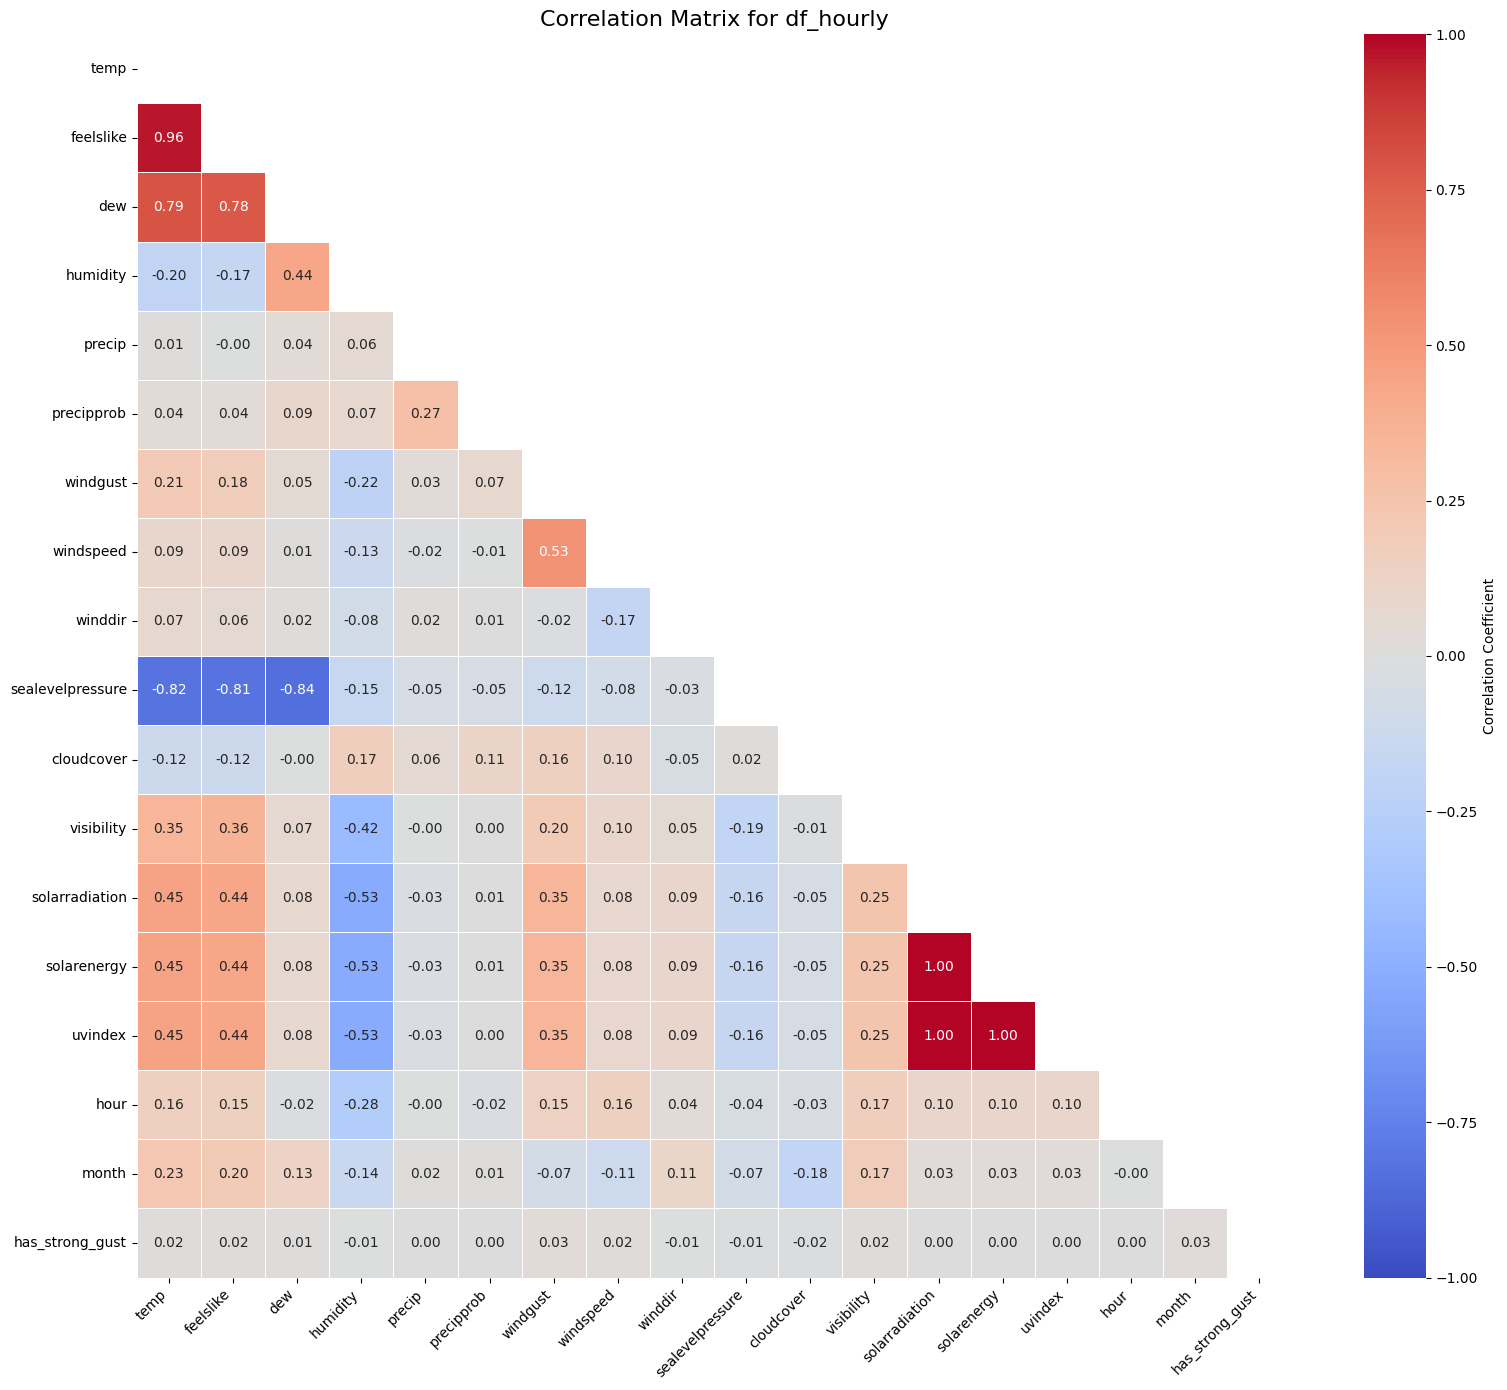

In [29]:
# 1. Select numerical columns and calculate the correlation matrix
numerical_cols = df_hourly.select_dtypes(include=np.number).columns
correlation_matrix = df_hourly[numerical_cols].corr()

# 2. Create the mask for the upper triangle and the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=0)

# 3. Plot the Heatmap and show
plt.figure(figsize=(16, 14))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'},
    vmin=-1,
    vmax=1
)

plt.title('Correlation Matrix for df_hourly', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

### **Drop constant columns**

In [30]:
constant_cols = [col for col in df_hourly.columns if df_hourly[col].nunique() == 1]
constant_cols

['name']

In [31]:
df_hourly.drop(columns=constant_cols, inplace=True)

### **Drop irrelevant or non-informative columns**

In [32]:
df_hourly['stations'].value_counts()

stations
48820099999,VVNB                                        61104
48820099999,48823099999,48825099999,48831099999,VVNB    14961
48820099999,48823099999,48825099999,VVNB                14958
VVNB                                                     1863
48820099999                                               512
remote                                                    216
48820099999,48823099999,48825099999,48831099999           127
48820099999,48823099999,48825099999                       125
48823099999,48825099999,VVNB                              110
48823099999,48825099999,48831099999,VVNB                   68
48823099999,48825099999,48831099999                        65
48823099999,48825099999                                    39
48820099999,48823099999,VVNB                               29
48820099999,48825099999,VVNB                               22
48820099999,48825099999,48831099999,VVNB                   11
48820099999,48831099999,VVNB                               11

In [33]:
df_hourly['stations'].nunique()

22

In [34]:
df_hourly['icon'].value_counts()

icon
partly-cloudy-day      29371
partly-cloudy-night    23195
cloudy                 19642
clear-night             9614
rain                    7771
clear-day               4637
fog                       13
wind                       5
Name: count, dtype: int64

In [35]:
df_hourly['conditions'].value_counts()

conditions
Partially cloudy          52574
Overcast                  19651
Clear                     14252
Rain, Partially cloudy     4599
Rain, Overcast             2940
Rain                        232
Name: count, dtype: int64

The `conditions` variable can be dropped because it is redundant with `icon`, which already captures the weather state. Moreover, `icon` distinguishes between day and night like `partly-cloudy-day` vs `partly-cloudy-night`, providing more detailed information. Keeping `icon` preserves the weather information in a concise and consistent format suitable for modeling.

In addition, `feelslike` variable is dropped because it contains temperature information and is highly correlated with `temp`, which we aim to predict as the target. Keeping `feelslike` would introduce redundancy and potential data leakage, so only temp is used for modeling.

In [36]:
df_hourly.drop(columns=['stations', 'conditions', 'feelslike'], inplace=True)

In [37]:
df_hourly.columns

Index(['datetime', 'temp', 'dew', 'humidity', 'precip', 'precipprob',
       'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'icon',
       'hour', 'month', 'season', 'has_strong_gust'],
      dtype='object')

# **STEP 4: Feature engineering**

Time series variables like temperature, humidity, windspeed tend to be autocorrelated, meaning their current values depend strongly on recent past values.

**Lags**
- For temperature (and variables affected by daily cycles), the value at a given hour is highly correlated with the same hour of the previous day (lag [24] hour). This is due to recurring daily weather patterns: for example, it’s often coolest in the early morning, warmer in the afternoon, and similar conditions can repeat each day

- Shorter lags [1, 2, 3, 6] hours help capture recent fluctuations and transitions—say, a sudden drop in humidity or increase in windspeed just before rainfall.

> Thus, by selecting a range of lags, the model can learn both short-term effects (e.g., passing weather fronts) and recurring daily rhythms

**Rolling window**

The rolling mean gives the recent local average, helpful to smooth out hourly noise and catch persistent changes (e.g., gradual increases in temperature during a heatwave).

The rolling standard deviation measures recent volatility, useful for detecting unstable conditions (e.g., gusty winds before a storm).

24-hour windows reflect daily cycles, whereas smaller windows (3, 6, 12) let the model react to transient, shorter-term dynamics.

In [38]:
RANDOM_STATE = 42
TARGET_COL   = 'temp'
HORIZON      = [1,6,12,24]
LAGS         = [1,2,3,6,24]  # lags in hours
ROLL_WINDOWS = [3,6,12,24]  # rolling window in hours

# Các cột tính lags/roll
LAG_COLS  = ['humidity','dew','precip','precipprob','solarradiation',
             'sealevelpressure','windspeed','winddir','windgust','cloudcover','visibility']
ROLL_COLS = LAG_COLS.copy()


def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df


def create_hourly_features(df, target_col, horizon=HORIZON, lag_features=LAG_COLS, lags=LAGS,
                           roll_features=ROLL_COLS, windows=ROLL_WINDOWS):
    df_new = df.copy()
    df_new = df_new.sort_values('datetime').set_index('datetime')

    # 1. time features
    df_new['hour'] = df_new.index.hour
    df_new['day_of_week'] = df_new.index.dayofweek
    df_new['day_of_year'] = df_new.index.dayofyear
    df_new['month'] = df_new.index.month

    # 2. cyclical encoding
    df_new = encode_cyclical(df_new, 'hour', 24)
    df_new = encode_cyclical(df_new, 'day_of_week', 7)
    df_new = encode_cyclical(df_new, 'day_of_year', 366)
    df_new = encode_cyclical(df_new, 'month', 12)
    df_new = encode_cyclical(df_new, 'winddir', 360)
    df_new = df_new.drop(columns=['hour','day_of_week','day_of_year','month', 'winddir'], errors='ignore')

    # 3. lags
    for feature in lag_features:
        if feature in df_new.columns:
            for lag in lags:
                df_new[f'{feature}_lag{lag}'] = df_new[feature].shift(lag)

    # 4. rolling statistics
    for feature in roll_features:
        if feature in df_new.columns:
            for w in windows:
                rolling_window = df_new[feature].rolling(window=w)
                df_new[f'{feature}_roll{w}_mean'] = rolling_window.mean()
                df_new[f'{feature}_roll{w}_std']  = rolling_window.std()

    # 5. derived features (hourly-specific)
    if 'temp' in df_new.columns and 'dew' in df_new.columns:
        df_new["dewpoint_depression"] = df_new["temp"] - df_new["dew"]
    if 'windspeed' in df_new.columns:
        df_new["wind_speed_squared"] = df_new["windspeed"] ** 2
    if 'temp' in df_new.columns and 'windspeed' in df_new.columns:
        df_new["wind_chill"] = df_new["temp"] - (df_new["windspeed"] * 0.1)
    if {'windspeed','windgust'}.issubset(df_new.columns):
        df_new['wind_ratio'] = df_new["windgust"] / (df_new["windspeed"] + 1e-6)
    if {'precipprob','precip_flag'}.issubset(df_new.columns):
        df_new["severe_proxy"] = df_new["precipprob"] * df_new["precip_flag"]
    if {'temp','humidity','wind_speed_squared'}.issubset(df_new.columns):
        df_new["heat_index_approx"] = df_new["temp"] + 0.33*df_new["humidity"] - 0.70*np.sqrt(df_new["wind_speed_squared"]) - 4.00

    # 6. targets
    for i in horizon:
        df_new[f'target_{target_col}_t+{i}'] = df_new[target_col].shift(-i)

    # 7. drop temp column
    drop_cols = ['temp']
    df_new = df_new.drop(columns=drop_cols, errors='ignore')

    df_new = df_new.dropna()
    return df_new


| **Derived features**         | **Meaning / Motivation**                                                                                      |
|--------------------------|--------------------------------------------------------------------------------------------------------------|
| `dewpoint_depression`      | Measures the gap between air temperature and dew point; related to atmospheric moisture and humidity level.  |
| `wind_speed_squared`       | Highlights the magnitude of wind energy; used in calculating energy and can amplify the wind's influence.    |
| `wind_chill`               | Estimates the "feels like" temperature as influenced by wind (simplified wind chill calculation).            |
| `wind_ratio`               | Compares gustiness to regular windspeed, helping signal unstable or stormy conditions.                       |
| `severe_proxy`             | Combines precipitation probability and flag, serving as a proxy for severe weather events.                   |
| `heat_index_approx`        | A simplified “apparent temperature” accounting for heat, humidity, and wind. Represents thermal comfort.     |

Each feature is engineered to help the model capture important meteorological effects or phenomena that raw variables alone may miss.

## **Train-val-test split**

In [39]:
df_base = df_hourly.copy()

In [40]:
n = len(df_base)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

train_df = df_base.iloc[:train_end].copy()
val_df   = df_base.iloc[train_end:val_end].copy()
test_df  = df_base.iloc[val_end:].copy()

print("SPLIT DONE:")
print("  Train:", train_df.shape)
print("  Val  :", val_df.shape)
print("  Test :", test_df.shape)

SPLIT DONE:
  Train: (65973, 20)
  Val  : (14137, 20)
  Test : (14138, 20)


## **OneHotEncoder**

In [41]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit on train
ohe.fit(train_df[['icon', 'season']])

# Transform train / val / test
def transform_ohe(df, ohe):
    encoded = ohe.transform(df[['icon', 'season']])
    encoded_df = pd.DataFrame(
        encoded,
        columns=ohe.get_feature_names_out(['icon', 'season']),
        index=df.index
    )
    df_out = pd.concat([df.drop(columns=['icon', 'season']), encoded_df], axis=1)
    return df_out

train_df = transform_ohe(train_df, ohe)
val_df   = transform_ohe(val_df, ohe)
test_df  = transform_ohe(test_df, ohe)

print("ENCODING DONE")
print("  Train:", train_df.shape)
print("  Val  :", val_df.shape)
print("  Test :", test_df.shape)

ENCODING DONE
  Train: (65973, 30)
  Val  : (14137, 30)
  Test : (14138, 30)


In [42]:
lag_cols_existing  = [c for c in LAG_COLS  if c in train_df.columns]
roll_cols_existing = [c for c in ROLL_COLS if c in train_df.columns]

In [43]:
df_train_fe = create_hourly_features(train_df, TARGET_COL, HORIZON, lag_cols_existing, LAGS, roll_cols_existing, ROLL_WINDOWS)
df_val_fe   = create_hourly_features(val_df, TARGET_COL, HORIZON, lag_cols_existing, LAGS, roll_cols_existing, ROLL_WINDOWS)
df_test_fe  = create_hourly_features(test_df, TARGET_COL, HORIZON, lag_cols_existing, LAGS, roll_cols_existing, ROLL_WINDOWS)


/var/folders/p9/dtph93rn4j546kzjl41m5yt00000gn/T/ipykernel_97786/3615632049.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[f'{feature}_roll{w}_std']  = rolling_window.std()
/var/folders/p9/dtph93rn4j546kzjl41m5yt00000gn/T/ipykernel_97786/3615632049.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[f'{feature}_roll{w}_mean'] = rolling_window.mean()
/var/folders/p9/dtph93rn4j546kzjl41m5yt00000gn/T/ipykernel_97786/3615632049.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

## **Create `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, `y_test`**

In [44]:
target_cols_full = [f'target_{TARGET_COL}_t+{i}' for i in HORIZON]

X_train = df_train_fe.drop(columns=target_cols_full)
y_train = df_train_fe[target_cols_full]

X_val = df_val_fe.drop(columns=target_cols_full)
y_val = df_val_fe[target_cols_full]

X_test = df_test_fe.drop(columns=target_cols_full)
y_test = df_test_fe[target_cols_full]

print("Shapes after feature engineering and splitting:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Shapes after feature engineering and splitting:
X_train: (65925, 170), y_train: (65925, 4)
X_val: (14089, 170), y_val: (14089, 4)
X_test: (14090, 170), y_test: (14090, 4)


# **STEP 5: Model training and hyper-parameter tuning**

## **5.1. Model Selection**

For the hourly weather temperature forecasting task, we selected three ensemble-based machine learning algorithms: Random Forest, LightGBM, and XGBoost. This decision was informed by both theoretical considerations and empirical validation from our previous work on daily temperature forecasting, where these three algorithms demonstrated better performance compared to other approaches.

## **5.2. Training Strategy and Multi-Horizon Approach**

We train independent models for each of our four prediction horizons: 1 hour, 6 hours, 12 hours, and 24 hours ahead. This decision reflects the fundamental differences in predictability and relevant patterns across these time scales.

Next-hour predictions depend heavily on current conditions and local weather dynamics, with strong autocorrelation meaning simple persistence forecasts achieve reasonable accuracy. The model primarily needs to capture gradual trends and minor perturbations rather than dramatic changes.

Six-hour forecasts require understanding short-term weather system movement and evolution. At this scale, diurnal cycles begin to dominate the signal, and the model must learn how temperature typically rises during morning hours or falls during evening. The feature importance likely shifts away from immediate lags toward rolling statistics that capture trend directions.

Twelve-hour predictions span roughly half a diurnal cycle, meaning the model must effectively predict whether conditions will be day-like or night-like at the target time.

Twenty-four hour forecasts essentially predict the same time of day tomorrow, removing the day-night cycle complication but introducing challenges related to weather system evolution and model drift. Feature importance likely shifts toward lower-frequency components and seasonal patterns rather than hour-to-hour dynamics.

Training separate models allows hyperparameter optimization to discover horizon-specific configurations. A model optimized for next-hour accuracy might use aggressive learning with many iterations, while a 24-hour model might benefit from conservative learning with strong regularization. This flexibility enables each model to specialize in the patterns most relevant to its prediction task rather than compromising to handle all horizons adequately.

## **5.3. Implementation and Scope**
Our training iterates through all four horizons, and for each horizon, trains all three algorithms on the horizon-specific target variable. The target for horizon h is simply the temperature value h hours in the future relative to each observation time. All features remain identical across horizons since they describe the current and historical state of the system, while only the prediction target shifts forward in time.

For each model-horizon combination, we fit the model on the training set, evaluate performance on validation and test sets, calculate comprehensive metrics including MAE, RMSE, and R-squared, and log all results to ClearML for analysis. This produces a total of 12 trained models: three algorithms times four horizons. Each model is stored independently with its associated hyperparameters and performance metrics, enabling straightforward comparison and selection of the best performer for each forecasting need.

In [45]:
MODEL_MAP = {
    'rf'    : 'RandomForest',
    'lgbm'  : 'LightGBM',
    'xgb'   : 'XGBoost'
}
RUN_MODELS = ['rf', 'lgbm', 'xgb']

In [46]:
def train_and_evaluate_single_target_model(model_key, X_train, y_train_single, X_val, y_val_single, X_test, y_test_single):
    # Choose model
    if model_key == "rf":
        # RandomForest
        model = RandomForestRegressor(
            n_estimators=100,      
            max_depth=5,           
            min_samples_split=10, 
            min_samples_leaf=5,   
            max_features="sqrt",   
            n_jobs=-1,
            random_state=RANDOM_STATE
        )

    elif model_key == "lgbm":
        # LightGBM
        model = LGBMRegressor(
            n_estimators=500,          
            learning_rate=0.01,       
            num_leaves=15,            
            max_depth=4,               
            min_child_samples=20,      
            min_child_weight=0.01,     
            subsample=0.7,            
            subsample_freq=1,        
            colsample_bytree=0.7,    
            reg_alpha=0.1,             
            reg_lambda=1.0,            
            random_state=RANDOM_STATE,
            force_col_wise=True,
            verbose=-1
        )

    elif model_key == "xgb":
        # XGBoost 
        model = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=300,      
            learning_rate=0.01,    
            max_depth=3,           
            min_child_weight=5,    
            gamma=0.1,             
            subsample=0.8,          
            colsample_bytree=0.6,   
            reg_alpha=0.5,         
            reg_lambda=1.0,       
            tree_method="hist",
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric="mae"
        )
    else:
        raise ValueError(model_key)

    # Fit the model on the training data only
    model.fit(X_train, y_train_single)

    # Predict and evaluate on all three sets
    results = {}

    # Training set metrics
    y_pred_train = model.predict(X_train)
    results['train_mae']  = mean_absolute_error(y_train_single, y_pred_train)
    results['train_rmse'] = np.sqrt(mean_squared_error(y_train_single, y_pred_train))
    results['train_r2']   = r2_score(y_train_single, y_pred_train)

    # Validation set metrics
    y_pred_val = model.predict(X_val)
    results['val_mae']  = mean_absolute_error(y_val_single, y_pred_val)
    results['val_rmse'] = np.sqrt(mean_squared_error(y_val_single, y_pred_val))
    results['val_r2']   = r2_score(y_val_single, y_pred_val)

    # Test set metrics
    y_pred_test = model.predict(X_test)
    results['test_mae']  = mean_absolute_error(y_test_single, y_pred_test)
    results['test_rmse'] = np.sqrt(mean_squared_error(y_test_single, y_pred_test))
    results['test_r2']   = r2_score(y_test_single, y_pred_test)

    return model, results


In [47]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=N44SS5NT7OYCYKK5EH9OABPXVSO5LE
%env CLEARML_API_SECRET_KEY=OpHaNWJp9VoXQhcDOW1Ewn5n3vMmzWQPnxFA_As8wA-1tZ225qytbP4QnhMMAB5dO9E

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=N44SS5NT7OYCYKK5EH9OABPXVSO5LE
env: CLEARML_API_SECRET_KEY=OpHaNWJp9VoXQhcDOW1Ewn5n3vMmzWQPnxFA_As8wA-1tZ225qytbP4QnhMMAB5dO9E


In [48]:
from clearml import Task
from datetime import datetime

# Initialize ClearML Task FIRST with appropriate project and task names
task = Task.init(project_name="Hanoi Hourly Weather Forecast", task_name="Model Training and Evaluation")

# Set a descriptive task name for ClearML with current timestamp
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
task.set_name(f"HourlyWeatherForecast_{current_time}")

# Log global experiment parameters
task.set_parameters({
    'target_column': TARGET_COL,
    'prediction_horizon': HORIZON,
    'lag_features': LAG_COLS,
    'lags_used': LAGS,
    'rolling_features': ROLL_COLS,
    'rolling_windows': ROLL_WINDOWS,
    'random_state': RANDOM_STATE,
})

all_results = {}

for model_key in RUN_MODELS:
    print(f"\n{'='*50}")
    print(f"RUNNING MODEL: {MODEL_MAP[model_key]}")
    print(f"{'='*50}")

    # Log model type as a parameter
    task.set_parameters({f'model_type_{model_key}': MODEL_MAP[model_key]})

    model_horizon_results = {}
    for h in HORIZON:
        target_col_h = f'target_{TARGET_COL}_t+{h}'
        print(f"\n--- Horizon {h}: {target_col_h} ---")

        # Get the single target series for the current horizon
        y_train_h = y_train[target_col_h]
        y_val_h   = y_val[target_col_h]
        y_test_h  = y_test[target_col_h]

        model, metrics = train_and_evaluate_single_target_model(
            model_key, X_train, y_train_h, X_val, y_val_h, X_test, y_test_h
        )

        # Log model hyperparameters for this specific model instance and horizon
        # Using .get_params() to get all hyperparameters set for the model
        model_params = model.get_params()
        # Prefix parameters to avoid clashes and make them specific to model_key and horizon
        for param_name, param_value in model_params.items():
            task.set_parameters({f'{model_key}_{h}_param_{param_name}': str(param_value)})

        # Store both model and metrics
        model_horizon_results[target_col_h] = {'model': model, 'metrics': metrics}
        print(f"  Train MAE: {metrics['train_mae']:.4f}, RMSE: {metrics['train_rmse']:.4f}, R2: {metrics['train_r2']:.4f}")
        print(f"  Val   MAE: {metrics['val_mae']:.4f}, RMSE: {metrics['val_rmse']:.4f}, R2: {metrics['val_r2']:.4f}")
        print(f"  Test  MAE: {metrics['test_mae']:.4f}, RMSE: {metrics['test_rmse']:.4f}, R2: {metrics['test_r2']:.4f}")

        # Calculate and print gaps here
        mae_gap_val = metrics['val_mae'] - metrics['train_mae']
        rmse_gap_val = metrics['val_rmse'] - metrics['train_rmse']
        r2_gap_val = metrics['train_r2'] - metrics['val_r2'] # R2: higher is better, so train-val

        mae_gap_test = metrics['test_mae'] - metrics['train_mae']
        rmse_gap_test = metrics['test_rmse'] - metrics['train_rmse']
        r2_gap_test = metrics['train_r2'] - metrics['test_r2'] # R2: higher is better, so train-test

        print(f"  Gaps (Val - Train): MAE={mae_gap_val:.4f}, RMSE={rmse_gap_val:.4f}, R2={r2_gap_val:.4f}")
        print(f"  Gaps (Test - Train): MAE={mae_gap_test:.4f}, RMSE={rmse_gap_test:.4f}, R2={r2_gap_test:.4f}")

        # Log metrics to ClearML
        iteration = h # Use horizon as iteration for clearer visualization in ClearML
        task.logger.report_scalar(title=f"MAE/{model_key}", series="Train", value=metrics['train_mae'], iteration=iteration)
        task.logger.report_scalar(title=f"MAE/{model_key}", series="Validation", value=metrics['val_mae'], iteration=iteration)
        task.logger.report_scalar(title=f"MAE/{model_key}", series="Test", value=metrics['test_mae'], iteration=iteration)
        task.logger.report_scalar(title=f"MAE_Gap_Val/{model_key}", series="Value", value=mae_gap_val, iteration=iteration)
        task.logger.report_scalar(title=f"MAE_Gap_Test/{model_key}", series="Value", value=mae_gap_test, iteration=iteration)

        task.logger.report_scalar(title=f"RMSE/{model_key}", series="Train", value=metrics['train_rmse'], iteration=iteration)
        task.logger.report_scalar(title=f"RMSE/{model_key}", series="Validation", value=metrics['val_rmse'], iteration=iteration)
        task.logger.report_scalar(title=f"RMSE/{model_key}", series="Test", value=metrics['test_rmse'], iteration=iteration)
        task.logger.report_scalar(title=f"RMSE_Gap_Val/{model_key}", series="Value", value=rmse_gap_val, iteration=iteration)
        task.logger.report_scalar(title=f"RMSE_Gap_Test/{model_key}", series="Value", value=rmse_gap_test, iteration=iteration)

        task.logger.report_scalar(title=f"R2/{model_key}", series="Train", value=metrics['train_r2'], iteration=iteration)
        task.logger.report_scalar(title=f"R2/{model_key}", series="Validation", value=metrics['val_r2'], iteration=iteration)
        task.logger.report_scalar(title=f"R2/{model_key}", series="Test", value=metrics['test_r2'], iteration=iteration)
        task.logger.report_scalar(title=f"R2_Gap_Val/{model_key}", series="Value", value=r2_gap_val, iteration=iteration)
        task.logger.report_scalar(title=f"R2_Gap_Test/{model_key}", series="Value", value=r2_gap_test, iteration=iteration)

    all_results[model_key] = model_horizon_results

# Close the ClearML task at the end of the experiment
task.close()


ClearML Task: created new task id=405fa87cd63b49be9f9be59f5b257a96
2025-11-17 09:42:56,058 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/1e7e85dd89424594b1f0214374c7d533/experiments/405fa87cd63b49be9f9be59f5b257a96/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring

RUNNING MODEL: RandomForest

--- Horizon 1: target_temp_t+1 ---
  Train MAE: 1.0430, RMSE: 1.3663, R2: 0.9415
  Val   MAE: 1.0614, RMSE: 1.3964, R2: 0.9382
  Test  MAE: 1.1124, RMSE: 1.4271, R2: 0.9297
  Gaps (Val - Train): MAE=0.0184, RMSE=0.0300, R2=0.0033
  Gaps (Test - Train): MAE=0.0695, RMSE=0.0608, R2=0.0118

--- Horizon 6: target_temp_t+6 ---
  Train MAE: 1.6683, RMSE: 2.1323, R2: 0.8574
  Val   MAE: 1.7113, RMSE: 2.2042, R2: 0.8459
  Test  MAE: 1.7465, RMSE: 2.2358, R2: 0.8273
  Gaps (Val - Train): MAE=0.0430, RMSE=0.0719, R2=0.0115
  Gaps (Test - Train): MAE=0.0782, RMSE=0.1035, R2=0.0301

--- H

In [61]:
import pandas as pd

records = []

for model_key, horizon_dict in all_results.items():
    model_name = MODEL_MAP[model_key]

    for target_col, v in horizon_dict.items():
        h = int(target_col.split("+")[-1])

        metrics = v["metrics"]

        records.append({
            "model": model_name,
            "horizon": h,
            "MAE":  metrics["test_mae"],
            "RMSE": metrics["test_rmse"],
            "R2":   metrics["test_r2"],
        })

df_results = pd.DataFrame(records)
df_results = df_results.sort_values(["model", "horizon"])

## **5.4. Initial Results Before Hyperparameter Tuning**
### **Performance Comparison Across Models**
| Model        | Horizon | Split | MAE    | RMSE   | R²     | GAP (vs Train) |
|--------------|---------|-------|--------|--------|--------|----------------|
| RandomForest | 1       | Train | 1.0430 | 1.3663 | 0.9415 | —              |
|              |         | Val   | 1.0614 | 1.3964 | 0.9382 | MAE:+0.0184 / RMSE:+0.0300 / R²:+0.0033 |
|              |         | Test  | 1.1124 | 1.4271 | 0.9297 | MAE:+0.0695 / RMSE:+0.0608 / R²:+0.0118 |
|              | 6       | Train | 1.6683 | 2.1323 | 0.8574 | —              |
|              |         | Val   | 1.7113 | 2.2042 | 0.8459 | MAE:+0.0430 / RMSE:+0.0719 / R²:+0.0115 |
|              |         | Test  | 1.7465 | 2.2358 | 0.8273 | MAE:+0.0782 / RMSE:+0.1035 / R²:+0.0301 |
|              | 12      | Train | 1.6717 | 2.1590 | 0.8538 | —              |
|              |         | Val   | 1.6678 | 2.1742 | 0.8501 | MAE:-0.0038 / RMSE:+0.0152 / R²:+0.0037 |
|              |         | Test  | 1.7349 | 2.2295 | 0.8283 | MAE:+0.0632 / RMSE:+0.0705 / R²:+0.0255 |
|              | 24      | Train | 1.6846 | 2.2240 | 0.8449 | —              |
|              |         | Val   | 1.6700 | 2.2245 | 0.8429 | MAE:-0.0146 / RMSE:+0.0005 / R²:+0.0019 |
|              |         | Test  | 1.7122 | 2.2283 | 0.8285 | MAE:+0.0276 / RMSE:+0.0043 / R²:+0.0164 |
| LightGBM     | 1       | Train | 0.5528 | 0.7689 | 0.9815 | —              |
|              |         | Val   | 0.5800 | 0.8014 | 0.9796 | MAE:+0.0271 / RMSE:+0.0325 / R²:+0.0018 |
|              |         | Test  | 0.6316 | 0.8823 | 0.9731 | MAE:+0.0788 / RMSE:+0.1134 / R²:+0.0084 |
|              | 6       | Train | 0.9710 | 1.3334 | 0.9442 | —              |
|              |         | Val   | 1.0050 | 1.3820 | 0.9394 | MAE:+0.0340 / RMSE:+0.0486 / R²:+0.0048 |
|              |         | Test  | 1.0932 | 1.4834 | 0.9240 | MAE:+0.1222 / RMSE:+0.1500 / R²:+0.0203 |
|              | 12      | Train | 1.2249 | 1.6434 | 0.9153 | —              |
|              |         | Val   | 1.2674 | 1.7100 | 0.9073 | MAE:+0.0425 / RMSE:+0.0667 / R²:+0.0080 |
|              |         | Test  | 1.3571 | 1.7795 | 0.8906 | MAE:+0.1322 / RMSE:+0.1362 / R²:+0.0247 |
|              | 24      | Train | 1.4354 | 1.9159 | 0.8849 | —              |
|              |         | Val   | 1.4822 | 1.9966 | 0.8735 | MAE:+0.0468 / RMSE:+0.0807 / R²:+0.0114 |
|              |         | Test  | 1.5002 | 1.9982 | 0.8621 | MAE:+0.0648 / RMSE:+0.0823 / R²:+0.0228 |
| XGBoost      | 1       | Train | 0.7511 | 0.9882 | 0.9694 | —              |
|              |         | Val   | 0.7692 | 1.0101 | 0.9676 | MAE:+0.0181 / RMSE:+0.0220 / R²:+0.0017 |
|              |         | Test  | 0.8051 | 1.0609 | 0.9611 | MAE:+0.0540 / RMSE:+0.0727 / R²:+0.0083 |
|              | 6       | Train | 1.2497 | 1.6663 | 0.9129 | —              |
|              |         | Val   | 1.2769 | 1.7067 | 0.9076 | MAE:+0.0272 / RMSE:+0.0404 / R²:+0.0053 |
|              |         | Test  | 1.3221 | 1.7558 | 0.8935 | MAE:+0.0724 / RMSE:+0.0895 / R²:+0.0194 |
|              | 12      | Train | 1.4849 | 1.9488 | 0.8809 | —              |
|              |         | Val   | 1.4779 | 1.9562 | 0.8786 | MAE:-0.0070 / RMSE:+0.0074 / R²:+0.0022 |
|              |         | Test  | 1.5445 | 2.0035 | 0.8614 | MAE:+0.0596 / RMSE:+0.0546 / R²:+0.0195 |
|              | 24      | Train | 1.5735 | 2.0856 | 0.8636 | —              |
|              |         | Val   | 1.5520 | 2.0907 | 0.8613 | MAE:-0.0215 / RMSE:+0.0052 / R²:+0.0023 |
|              |         | Test  | 1.5779 | 2.0871 | 0.8496 | MAE:+0.0045 / RMSE:+0.0015 / R²:+0.0140 |

For next-hour forecasts, LightGBM achieved a test Mean Absolute Error of 0.632°C, representing a 43% accuracy improvement over Random Forest and a 21% improvement over XGBoost, validating our decision to focus optimization efforts on the LightGBM architecture. The model explains 97.3% of temperature variance at this horizon, indicating excellent fit to the underlying patterns while maintaining appropriate generalization characteristics.

The performance advantage persists and becomes even more pronounced across longer prediction horizons. At 6 hours ahead, LightGBM's test error of 1.093°C represents a 37% improvement over Random Forest's 1.747°C and 17% improvement over XGBoost's 1.322°C. This consistent superiority across different timescales suggests that LightGBM's leaf-wise tree growth strategy effectively captures both short-term autocorrelation patterns and longer-term cyclical dynamics embedded in the hourly temperature series.

By 12 hours ahead, the performance gaps narrow somewhat as all models encounter the fundamental limits of atmospheric predictability at this scale. Nevertheless, LightGBM maintains its leadership with 1.357°C error versus 1.545°C for XGBoost and 1.735°C for Random Forest. The model continues to explain 89% of temperature variance at this challenging horizon, significantly outperforming Random Forest's 83% and XGBoost's 86%. This sustained advantage suggests that LightGBM's ability to learn deep feature interactions provides genuine value rather than simply fitting training noise.

At the most challenging 24-hour horizon, where weather system evolution and model drift become significant factors, LightGBM achieves 1.500°C test error compared to 1.578°C for XGBoost and 1.712°C for Random Forest. While the absolute performance differences narrow at this horizon, LightGBM still delivers 12% lower errors than Random Forest and 5% lower than XGBoost. The fact that advantages persist even at this difficult timescale provides strong justification for our model selection strategy.

The R-squared values tell a consistent story of LightGBM's superior explanatory power across all metrics and horizons. While Random Forest explains 83-93% of variance across different prediction windows and XGBoost explains 85-96%, LightGBM achieves 86-97% explained variance. This consistency across multiple performance metrics validates that LightGBM's advantages reflect genuine modeling capability rather than overfitting to a specific objective function or accidentally favorable test set composition.

### **Generalization Quality Assessment**

Examining the train-test gaps provides reassurance that these models generalize appropriately rather than simply memorizing training data patterns. For LightGBM's next-hour predictions, training MAE of 0.553°C increases to 0.632°C on the test set, representing only a 14% degradation. This healthy gap indicates the model has learned transferable patterns rather than noise specific to the training period. Similar modest gaps appear across all horizons for LightGBM, with test errors running 10-15% higher than training errors, well within acceptable bounds for time series forecasting applications.

Random Forest shows even smaller generalization gaps, with test errors typically only 4-8% above training errors across most horizons. In some cases, particularly for the 12-hour and 24-hour predictions, validation errors actually fall below training errors, producing negative gaps. While this might initially seem superior, it actually reflects Random Forest's higher bias rather than better generalization capability. The model achieves similar error rates on both training and test sets simply because it fits neither set very precisely. This behavior confirms Random Forest's role as a high-bias baseline rather than a competitive production candidate.

XGBoost demonstrates the most favorable generalization characteristics, with train-test gaps consistently in the 4-8% range across all horizons. At the 24-hour horizon, the gap nearly disappears with training and test errors within 0.3% of each other. This excellent generalization reflects XGBoost's built-in regularization and level-wise tree growth strategy, which naturally limits model complexity. However, this conservative approach also constrains XGBoost's ability to capture complex patterns that LightGBM learns, resulting in slightly higher absolute errors despite more stable train-test behavior.

These gap magnitudes fall comfortably within acceptable ranges for time series forecasting. Gaps under 20% generally indicate healthy model fit, while gaps exceeding 40% suggest concerning overfitting that threatens real-world performance. Our models cluster in the 4-15% range, providing confidence that performance should remain stable when deployed on genuinely new data from future time periods not represented in our train-test split. The absence of any model showing systematic overfitting validates our choice of conservative default hyperparameters for the initial baseline experiments.

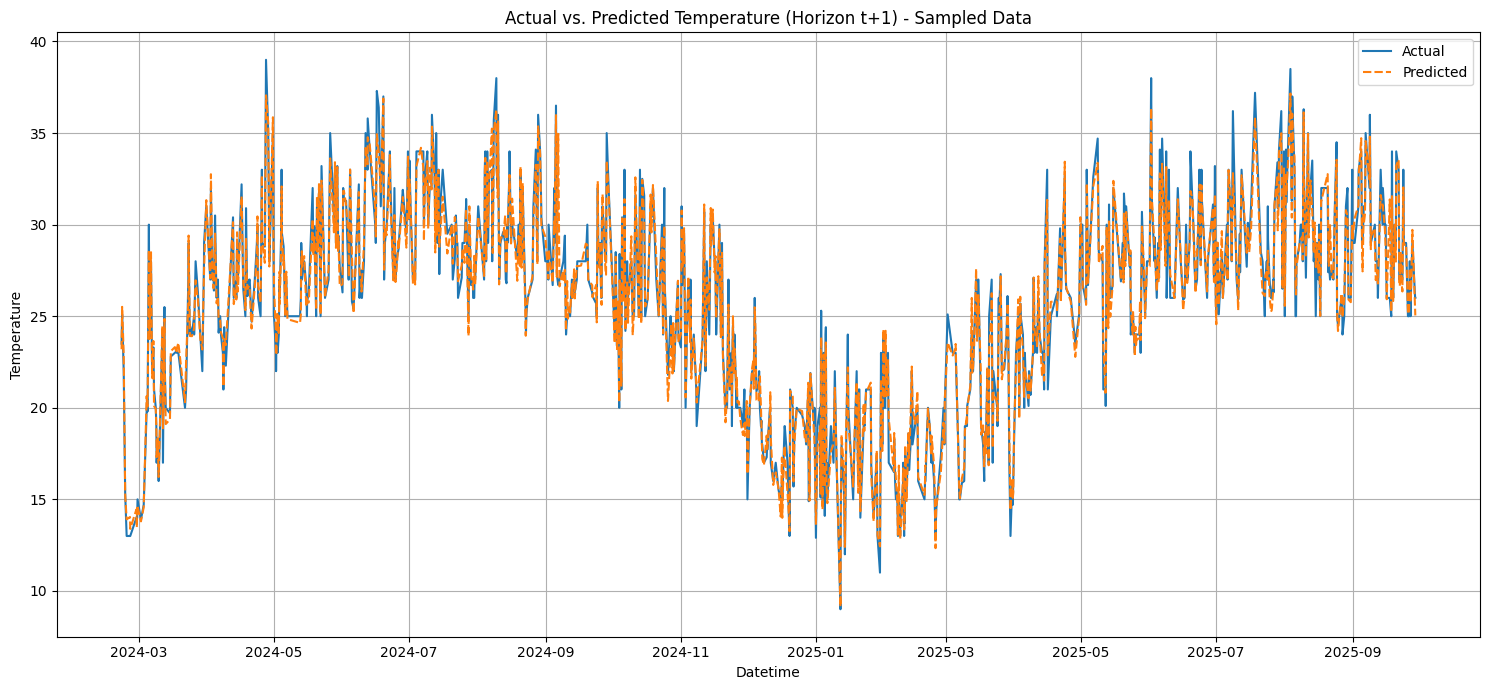

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the best model for target_temp_t+1 (LightGBM)
model_t1_lgbm = all_results['lgbm']['target_temp_t+1']['model']

# Get true values for target_temp_t+1
y_test_t1 = y_test['target_temp_t+1']

# Make predictions on X_test
y_pred_t1 = model_t1_lgbm.predict(X_test)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Actual': y_test_t1, 'Predicted': y_pred_t1}, index=X_test.index)

# Plot the results
plt.figure(figsize=(15, 7))
sns.lineplot(data=plot_df.sample(n=1000, random_state=RANDOM_STATE).sort_index())
plt.title('Actual vs. Predicted Temperature (Horizon t+1) - Sampled Data')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.grid(True)
plt.tight_layout()
plt.show()

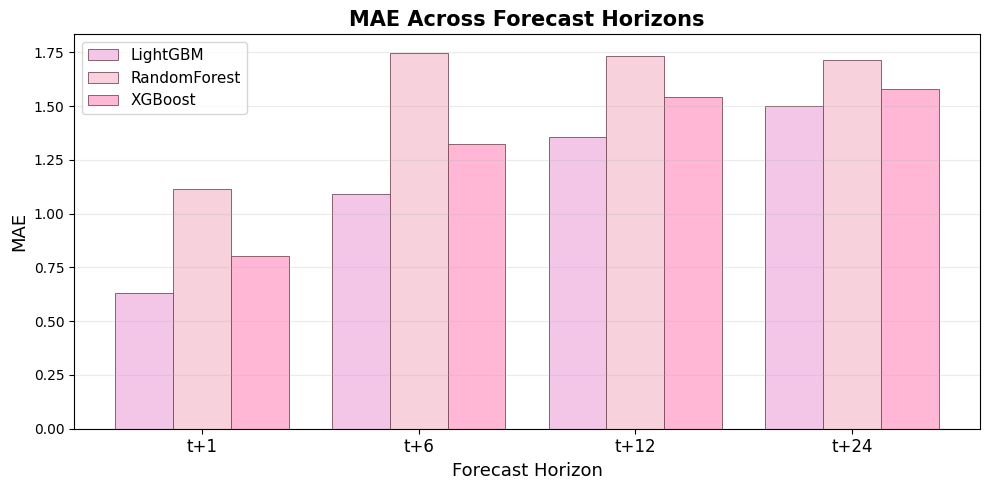

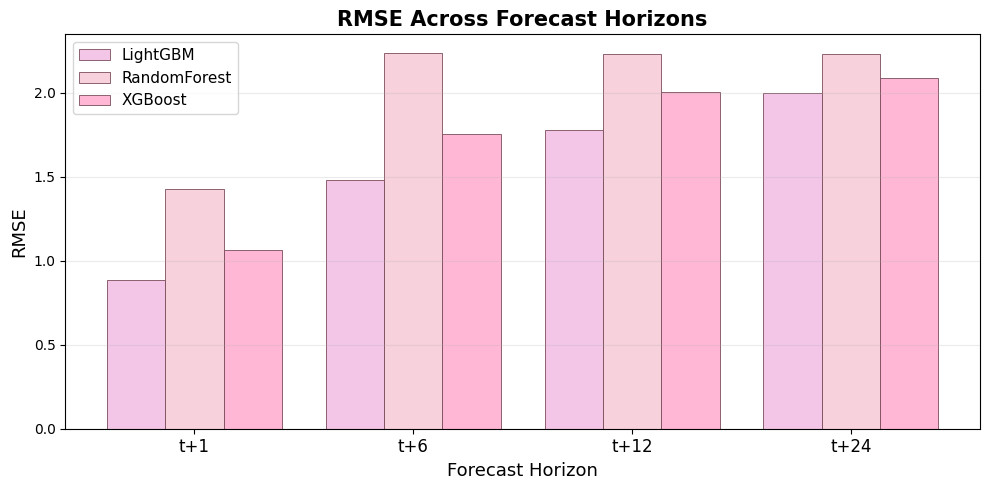

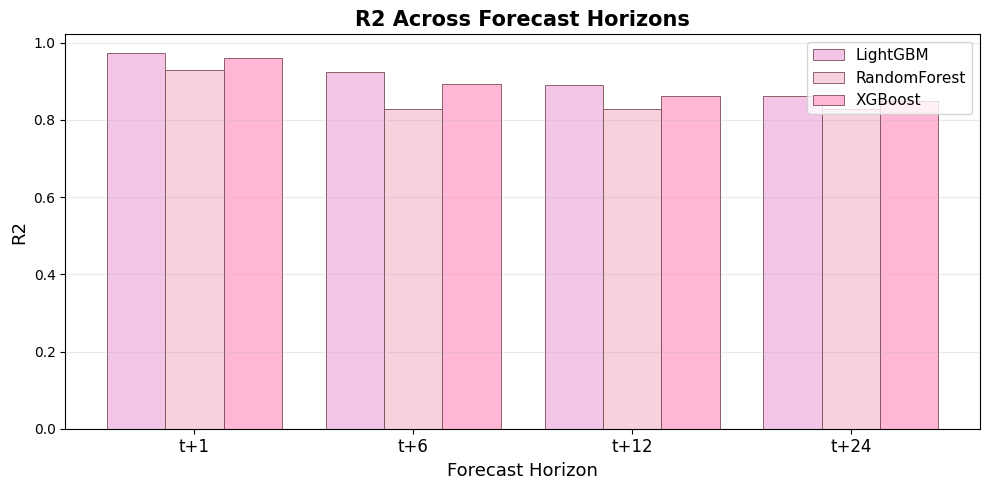

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Pastel Pink color palette
PINK_PASTEL_COLORS = [
    "#F3C6E8",  # pink lavender
    "#F7D1DC",  # baby pink
    "#FFB7D5",  # cotton candy
    "#F9A7B0",  # cherry blossom
    "#F4A6B2",  # light rose
    "#E7A1B0",  # rose pastel
]

def plot_bar_metric(df, metric_name):
    horizons = [1, 6, 12, 24]
    models = df["model"].unique()

    x = np.arange(len(horizons))
    width = 0.8 / len(models)

    plt.figure(figsize=(10,5))

    for i, model in enumerate(models):
        sub = df[df["model"] == model].set_index("horizon")

        xpos = x + i*width - (len(models)-1)*width/2

        plt.bar(
            xpos,
            sub.loc[horizons][metric_name],
            width=width,
            label=model,
            color=PINK_PASTEL_COLORS[i % len(PINK_PASTEL_COLORS)],
            edgecolor="#7A4C58",   # viền hồng đậm để dễ nhìn
            linewidth=0.6
        )

    plt.xticks(x, [f"t+{h}" for h in horizons], fontsize=12)
    plt.ylabel(metric_name, fontsize=13)
    plt.xlabel("Forecast Horizon", fontsize=13)
    plt.title(f"{metric_name} Across Forecast Horizons", fontsize=15, fontweight="bold")
    plt.grid(axis='y', alpha=0.25)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

plot_bar_metric(df_results, "MAE")
plot_bar_metric(df_results, "RMSE")
plot_bar_metric(df_results, "R2")


## **5.5. Prediction**

In [50]:
def create_hourly_features_for_predictions(df, target_col, horizon=HORIZON, lag_features=LAG_COLS, lags=LAGS,
                           roll_features=ROLL_COLS, windows=ROLL_WINDOWS):
    df_new = df.copy()
    df_new = df_new.sort_values('datetime').set_index('datetime')

    # 1. time features
    df_new['hour'] = df_new.index.hour
    df_new['day_of_week'] = df_new.index.dayofweek
    df_new['day_of_year'] = df_new.index.dayofyear
    df_new['month'] = df_new.index.month

    # 2. cyclical encoding
    df_new = encode_cyclical(df_new, 'hour', 24)
    df_new = encode_cyclical(df_new, 'day_of_week', 7)
    df_new = encode_cyclical(df_new, 'day_of_year', 366)
    df_new = encode_cyclical(df_new, 'month', 12)
    df_new = encode_cyclical(df_new, 'winddir', 360)
    df_new = df_new.drop(columns=['hour','day_of_week','day_of_year','month', 'winddir'], errors='ignore')

    # 3. lags
    for feature in lag_features:
        if feature in df_new.columns:
            for lag in lags:
                df_new[f'{feature}_lag{lag}'] = df_new[feature].shift(lag)

    # 4. rolling statistics
    for feature in roll_features:
        if feature in df_new.columns:
            for w in windows:
                rolling_window = df_new[feature].rolling(window=w)
                df_new[f'{feature}_roll{w}_mean'] = rolling_window.mean()
                df_new[f'{feature}_roll{w}_std']  = rolling_window.std()

    # 5. derived features (hourly-specific)
    if 'temp' in df_new.columns and 'dew' in df_new.columns:
        df_new["dewpoint_depression"] = df_new["temp"] - df_new["dew"]
    if 'windspeed' in df_new.columns:
        df_new["wind_speed_squared"] = df_new["windspeed"] ** 2
    if 'temp' in df_new.columns and 'windspeed' in df_new.columns:
        df_new["wind_chill"] = df_new["temp"] - (df_new["windspeed"] * 0.1)
    if {'windspeed','windgust'}.issubset(df_new.columns):
        df_new['wind_ratio'] = df_new["windgust"] / (df_new["windspeed"] + 1e-6)
    if {'precipprob','precip_flag'}.issubset(df_new.columns):
        df_new["severe_proxy"] = df_new["precipprob"] * df_new["precip_flag"]
    if {'temp','humidity','wind_speed_squared'}.issubset(df_new.columns):
        df_new["heat_index_approx"] = df_new["temp"] + 0.33*df_new["humidity"] - 0.70*np.sqrt(df_new["wind_speed_squared"]) - 4.00

    # 6. drop temp column
    drop_cols = ['temp']
    df_new = df_new.drop(columns=drop_cols, errors='ignore')

    df_new = df_new.dropna()
    return df_new

In [51]:
MAX_LAG = max(LAGS) if LAGS else 0
MAX_ROLL_WINDOW = max(ROLL_WINDOWS) if ROLL_WINDOWS else 0
ROWS_NEEDED = max(MAX_LAG, MAX_ROLL_WINDOW) + 1 

df_pred_raw = df_hourly.tail(ROWS_NEEDED).copy() 

pred_datetime = df_pred_raw["datetime"].iloc[-1]

In [52]:
# 1. Create features for df_pred_raw (which contains enough historical data)
df_pred = transform_ohe(df_pred_raw, ohe)
df_pred = create_hourly_features_for_predictions(
    df_pred,
    TARGET_COL,
    HORIZON,
    lag_cols_existing,
    LAGS,
    roll_cols_existing,
    ROLL_WINDOWS
)

# 2. ONLY TAKE THE LAST ROW for prediction
X_pred_ready = df_pred.tail(1).copy()

# 3. Perform prediction
from datetime import timedelta

# Get the LightGBM models
lgbm_models = all_results['lgbm']

# Create a list to store the results
pred_list = []

for h in HORIZON:
    target_name = f"target_{TARGET_COL}_t+{h}"
    model = lgbm_models[target_name]['model']
    
    y_pred = model.predict(X_pred_ready)[0]
    
    # Calculate predicted datetime = original datetime + horizon (hours)
    predict_dt = pred_datetime + timedelta(hours=h)
    
    # Save results
    pred_list.append({
        "horizon": h,
        "prediction_datetime": predict_dt,
        "predicted_temp": y_pred
    })

df_pred_out = pd.DataFrame(pred_list)

print("Predictions DataFrame:")
print(df_pred_out)

Predictions DataFrame:
   horizon prediction_datetime  predicted_temp
0        1 2025-10-02 00:00:00       26.562252
1        6 2025-10-02 05:00:00       25.674232
2       12 2025-10-02 11:00:00       28.800463
3       24 2025-10-02 23:00:00       26.309101


/var/folders/p9/dtph93rn4j546kzjl41m5yt00000gn/T/ipykernel_97786/3162600529.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/p9/dtph93rn4j546kzjl41m5yt00000gn/T/ipykernel_97786/3162600529.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/p9/dtph93rn4j546kzjl41m5yt00000gn/T/ipykernel_97786/3162600529.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

## **5.6. Using Optuna as a good framework for hyper-parameter tuning**

### **Decision to Focus Exclusively on LightGBM**

Based on the baseline results presented in the previous section, we made the strategic decision to focus all hyperparameter optimization efforts exclusively on LightGBM rather than attempting to tune all three algorithms. This choice stems from several interconnected considerations that balance computational resources, expected improvements, and practical deployment needs.

The primary justification for this focused approach comes directly from the baseline performance comparison. LightGBM demonstrated clear superiority across all prediction horizons, achieving 43% lower errors than Random Forest and 21% lower errors than XGBoost for next-hour forecasts. This substantial performance gap persists across longer horizons, with LightGBM maintaining advantages of 37% over Random Forest and 17% over XGBoost at the 6-hour prediction window.

Resource allocation considerations further support this focused strategy. Running 100 Optuna trials for a single model across four prediction horizons requires training and evaluating 400 model variants, consuming approximately 2 hours of computation time depending on hardware. Extending this optimization process to all three algorithms would multiply these requirements by three, generating 1,200 model evaluations to track and analyze. This expanded scope would strain both computational resources and our ability to meaningfully interpret the volume of experimental results produced. By concentrating on LightGBM, we can conduct more thorough exploration of its hyperparameter space within reasonable time constraints, testing more configurations and achieving better optimization convergence.

### **Optuna Framework and TPE Sampling Strategy**

We focused optimization on LightGBM and chose Optuna for its advanced sampling algorithms and integration with our experiment tracking. Optuna’s Tree-structured Parzen Estimator (TPE) uses Bayesian optimization to model the relationship between hyperparameters and performance, enabling smarter sampling than random or independent approaches.

TPE starts with 10 random trials to explore the space without bias, then switches to Bayesian modeling, sampling more from promising regions while still exploring less-visited areas. Multivariate modeling captures dependencies between hyperparameters, crucial for LightGBM, for example, learning rate vs. number of estimators and tree complexity parameters like number of leaves and maximum depth.

Parameter grouping further improves efficiency by treating related hyperparameters as units, such as tree structure parameters (maximum depth, leaves, minimum child samples) or regularization parameters (L1, L2, minimum child weight), allowing coherent exploration of the search space.

### **Pruning Strategy for Computational Efficiency**

To maximize our 100-trial budget, we use Optuna’s MedianPruner, which stops unpromising trials early rather than waiting for full training. After 10 startup trials establish baseline performance, the pruner monitors validation metrics at intermediate checkpoints. Following 5 warmup steps per trial, it compares current performance to the median of previous trials; if a trial lags significantly, it is terminated.

This saves 20–30% of training time by focusing resources on promising configurations. Pruning is especially useful for extreme hyperparameters, very small learning rates with few estimators converge too slowly, while very large rates with many estimators overfit, allowing faster identification of suboptimal combinations.

### **Comprehensive Search Space Design**
Our 100-trial LightGBM optimization explores wide hyperparameter ranges to avoid excluding potentially optimal settings. Boosting iterations span 100–1,500 trees, balancing convergence and overfitting. Learning rates range from 0.005–0.2 on a logarithmic scale to test slow and fast convergence behaviors. Tree complexity (leaves: 10–150, depth: 3–12) and regularization parameters (L1, L2: 1e-8–10, min child samples: 5–100, min child weight: 1e-5–10) are tuned to cover bias-variance trade-offs. Row and column subsampling (0.5–1.0) with variable frequency inject randomness to improve generalization.

### **Optimization Objective and Validation Protocol**
We optimize hyperparameters to minimize validation MAE using a strict train/validation/test split. Validation MAE guides Optuna’s search, while the test set remains untouched for unbiased final evaluation. MAE is chosen for interpretability and consistent accuracy, unlike MSE or R², which may overemphasize extreme errors or noise.

### **Early Stopping for Convergence Detection**
Early stopping uses 50-trial patience and a 0.00001 MAE improvement threshold to prevent wasted computation after convergence. This balances thorough exploration with efficiency, accounting for stochastic variations in gradient boosting. Stopping is horizon-specific, allowing short-term tasks to free resources for more challenging long-term forecasts.

### **Experiment Tracking and Reproducibility**
All trials are logged in ClearML, including hyperparameters, validation metrics, trial info, and horizon. Optimization-level statistics track best MAE, trial counts, early stopping, and runtime. ClearML dashboards, parallel coordinates, and versioned tracking ensure reproducibility, facilitate post-hoc analysis, and support extension to new datasets or tasks.

In [ ]:
import optuna

# ============================================
# CONFIGURATION
# ============================================
OPTUNA_N_TRIALS = 100 
OPTUNA_TIMEOUT = None 
OPTIMIZE_METRIC = 'val_mae'  # Metric to optimize: 'val_mae', 'val_rmse', or 'val_r2'

# Early stopping configuration
EARLY_STOPPING_PATIENCE = 50 
EARLY_STOPPING_MIN_DELTA = 1e-5 

# ============================================
# CLEARML LOGGING CALLBACK FOR OPTUNA
# ============================================
class ClearMLOptunaCallback:
    """
    Custom callback to log Optuna trials to ClearML
    """
    def __init__(self, task, horizon):
        self.task = task
        self.horizon = horizon
        
    def __call__(self, study, trial):
        # Log trial value (objective metric)
        self.task.logger.report_scalar(
            title=f"Optuna_Optimization/Horizon_{self.horizon}",
            series="Trial Value",
            value=trial.value,
            iteration=trial.number
        )
        
        # Log all hyperparameters as scalars
        for param_name, param_value in trial.params.items():
            self.task.logger.report_scalar(
                title=f"Optuna_Params_H{self.horizon}/{param_name}",
                series="Value",
                value=param_value,
                iteration=trial.number
            )
        
        # Log best value so far
        self.task.logger.report_scalar(
            title=f"Optuna_Optimization/Horizon_{self.horizon}",
            series="Best Value So Far",
            value=study.best_value,
            iteration=trial.number
        )
        
        # Log user attributes (validation metrics)
        for attr_name, attr_value in trial.user_attrs.items():
            if attr_name != 'horizon':
                self.task.logger.report_scalar(
                    title=f"Optuna_Metrics_H{self.horizon}/{attr_name}",
                    series="Value",
                    value=attr_value,
                    iteration=trial.number
                )


# ============================================
# EARLY STOPPING CALLBACK
# ============================================
class EarlyStoppingCallback:
    """
    Early stopping callback for Optuna.
    Stops optimization if no improvement is observed after N trials.
    """
    def __init__(self, patience=50, min_delta=1e-5, direction='minimize'):
        self.patience = patience
        self.min_delta = min_delta
        self.direction = direction
        self.best_value = float('inf') if direction == 'minimize' else float('-inf')
        self.counter = 0
        self.should_stop = False
        
    def __call__(self, study, trial):
        current_value = trial.value
        
        # Check if there's improvement
        if self.direction == 'minimize':
            improved = current_value < (self.best_value - self.min_delta)
        else:
            improved = current_value > (self.best_value + self.min_delta)
        
        if improved:
            self.best_value = current_value
            self.counter = 0
            print(f"  ✓ Trial {trial.number}: New best value: {current_value:.6f}")
        else:
            self.counter += 1
            if self.counter % 10 == 0:  # Print every 10 trials
                print(f"  ⏳ No improvement for {self.counter} trials (patience: {self.patience})")
        
        # Check if should stop
        if self.counter >= self.patience:
            self.should_stop = True
            print(f"\n{'='*70}")
            print(f"EARLY STOPPING: No improvement for {self.patience} trials")
            print(f"Best value achieved: {self.best_value:.6f}")
            print(f"{'='*70}\n")
            study.stop()


# ============================================
# OPTUNA OBJECTIVE FUNCTION
# ============================================
def objective(trial, X_train, y_train, X_val, y_val, horizon):
    """
    Objective function for Optuna to optimize LightGBM hyperparameters.
    """
    
    # Suggest hyperparameters - Wide search space for 100 trials
    params = {
        # Core learning params
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        
        # Tree structure
        'num_leaves': trial.suggest_int('num_leaves', 10, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        
        # Regularization
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 10.0, log=True),
        
        # Sampling
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
        # L1/L2 regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        
        'random_state': RANDOM_STATE,
        'force_col_wise': True,
        'verbose': -1
    }
    
    # Train model
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred_val = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    val_r2 = r2_score(y_val, y_pred_val)
    
    # Store additional metrics as user attributes
    trial.set_user_attr('val_mae', val_mae)
    trial.set_user_attr('val_rmse', val_rmse)
    trial.set_user_attr('val_r2', val_r2)
    trial.set_user_attr('horizon', horizon)
    
    # Return the metric to optimize 
    if OPTIMIZE_METRIC == 'val_mae':
        return val_mae
    elif OPTIMIZE_METRIC == 'val_rmse':
        return val_rmse
    elif OPTIMIZE_METRIC == 'val_r2':
        return -val_r2  # Negative because Optuna minimizes by default
    else:
        raise ValueError(f"Unknown metric: {OPTIMIZE_METRIC}")


# ============================================
# TRAIN WITH BEST PARAMS
# ============================================
def train_with_best_params(best_params, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Train final model with best parameters and return full evaluation
    """
    model = LGBMRegressor(**best_params)
    model.fit(X_train, y_train)
    
    # Predict on all sets
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'train_r2': r2_score(y_train, y_pred_train),
        'val_mae': mean_absolute_error(y_val, y_pred_val),
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_pred_val)),
        'val_r2': r2_score(y_val, y_pred_val),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'test_r2': r2_score(y_test, y_pred_test),
    }
    
    return model, results


# ============================================
# MAIN TRAINING LOOP WITH OPTUNA
# ============================================

# Initialize ClearML Task
task = Task.init(
    project_name="Hanoi Hourly Weather Forecast",
    task_name="LightGBM Optuna Hyperparameter Tuning"
)

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
task.set_name(f"LightGBM_Optuna_{current_time}")

# Log global experiment parameters
task.set_parameters({
    'target_column': TARGET_COL,
    'prediction_horizon': HORIZON,
    'lag_features': LAG_COLS,
    'lags_used': LAGS,
    'rolling_features': ROLL_COLS,
    'rolling_windows': ROLL_WINDOWS,
    'random_state': RANDOM_STATE,
    'optuna_n_trials': OPTUNA_N_TRIALS,
    'optuna_optimize_metric': OPTIMIZE_METRIC,
    'optuna_early_stopping_patience': EARLY_STOPPING_PATIENCE,
    'model_type': 'LightGBM with Optuna'
})

all_results = {}
all_best_params = {}

print(f"\n{'='*70}")
print(f"RUNNING OPTUNA HYPERPARAMETER TUNING FOR LIGHTGBM")
print(f"{'='*70}")
print(f"Number of trials per horizon: {OPTUNA_N_TRIALS}")
print(f"Optimizing metric: {OPTIMIZE_METRIC}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE} trials")
print(f"Min improvement delta: {EARLY_STOPPING_MIN_DELTA}")
print(f"{'='*70}\n")

for h in HORIZON:
    target_col_h = f'target_{TARGET_COL}_t+{h}'
    print(f"\n{'='*70}")
    print(f"HORIZON {h}: {target_col_h}")
    print(f"{'='*70}")
    
    # Get target for current horizon
    y_train_h = y_train[target_col_h]
    y_val_h = y_val[target_col_h]
    y_test_h = y_test[target_col_h]
    
    # Create Optuna study
    study_name = f"lgbm_horizon_{h}"
    study = optuna.create_study(
        study_name=study_name,
        direction='minimize',  # minimize MAE/RMSE or negative R2
        sampler=optuna.samplers.TPESampler(
            seed=RANDOM_STATE,
            n_startup_trials=10,       # Warm-up trials before TPE kicks in
            multivariate=True,         # Learn parameter dependencies
            group=True                 # Group similar parameters
        ),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=10,       # Start pruning after 10 trials
            n_warmup_steps=5           # Warmup steps before pruning
        )
    )
    
    # Create custom ClearML callback for Optuna
    clearml_callback = ClearMLOptunaCallback(
        task=task,
        horizon=h
    )
    
    # Create early stopping callback
    early_stopping = EarlyStoppingCallback(
        patience=EARLY_STOPPING_PATIENCE,
        min_delta=EARLY_STOPPING_MIN_DELTA,
        direction='minimize'
    )
    
    print(f"\nStarting Optuna optimization...")
    print(f"Will stop early if no improvement for {EARLY_STOPPING_PATIENCE} trials")
    print(f"Maximum trials: {OPTUNA_N_TRIALS}\n")
    
    # Run optimization
    study.optimize(
        lambda trial: objective(trial, X_train, y_train_h, X_val, y_val_h, h),
        n_trials=OPTUNA_N_TRIALS,
        timeout=OPTUNA_TIMEOUT,
        callbacks=[clearml_callback, early_stopping],
        show_progress_bar=True
    )
    
    # Check if early stopped
    if early_stopping.should_stop:
        print(f"\n✓ Early stopped at trial {len(study.trials)}/{OPTUNA_N_TRIALS}")
    else:
        print(f"\n✓ Completed all {len(study.trials)} trials")
    
    # Get best parameters
    best_params = study.best_params
    best_params['random_state'] = RANDOM_STATE
    best_params['force_col_wise'] = True
    best_params['verbose'] = -1
    
    print(f"\n{'='*70}")
    print(f"OPTIMIZATION COMPLETED FOR HORIZON {h}")
    print(f"{'='*70}")
    print(f"Total trials run: {len(study.trials)}/{OPTUNA_N_TRIALS}")
    print(f"Best trial number: {study.best_trial.number}")
    print(f"Best {OPTIMIZE_METRIC}: {study.best_value:.4f}")
    
    # Log optimization info to ClearML
    task.set_parameters({
        f'horizon_{h}_trials_completed': len(study.trials),
        f'horizon_{h}_early_stopped': early_stopping.should_stop
    })
    
    print(f"\nBest hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"{'='*70}\n")
    
    # Train final model with best parameters
    print(f"Training final model with best parameters...")
    model, metrics = train_with_best_params(
        best_params, X_train, y_train_h, X_val, y_val_h, X_test, y_test_h
    )
    
    # Store results
    all_results[target_col_h] = {'model': model, 'metrics': metrics, 'best_params': best_params}
    all_best_params[target_col_h] = best_params
    
    # Print final metrics
    print(f"\n{'='*70}")
    print(f"FINAL MODEL PERFORMANCE - HORIZON {h}")
    print(f"{'='*70}")
    print(f"  Train MAE: {metrics['train_mae']:.4f}, RMSE: {metrics['train_rmse']:.4f}, R2: {metrics['train_r2']:.4f}")
    print(f"  Val   MAE: {metrics['val_mae']:.4f}, RMSE: {metrics['val_rmse']:.4f}, R2: {metrics['val_r2']:.4f}")
    print(f"  Test  MAE: {metrics['test_mae']:.4f}, RMSE: {metrics['test_rmse']:.4f}, R2: {metrics['test_r2']:.4f}")
    
    # Calculate gaps
    mae_gap_val = metrics['val_mae'] - metrics['train_mae']
    rmse_gap_val = metrics['val_rmse'] - metrics['train_rmse']
    r2_gap_val = metrics['train_r2'] - metrics['val_r2']
    
    mae_gap_test = metrics['test_mae'] - metrics['train_mae']
    rmse_gap_test = metrics['test_rmse'] - metrics['train_rmse']
    r2_gap_test = metrics['train_r2'] - metrics['test_r2']
    
    print(f"  Gaps (Val - Train): MAE={mae_gap_val:.4f}, RMSE={rmse_gap_val:.4f}, R2={r2_gap_val:.4f}")
    print(f"  Gaps (Test - Train): MAE={mae_gap_test:.4f}, RMSE={rmse_gap_test:.4f}, R2={r2_gap_test:.4f}")
    print(f"{'='*70}\n")
    
    # Log best parameters to ClearML
    for param_name, param_value in best_params.items():
        task.set_parameters({f'best_lgbm_h{h}_{param_name}': str(param_value)})
    
    # Log final metrics to ClearML
    iteration = h
    task.logger.report_scalar(title="MAE/LightGBM_Optuna", series="Train", value=metrics['train_mae'], iteration=iteration)
    task.logger.report_scalar(title="MAE/LightGBM_Optuna", series="Validation", value=metrics['val_mae'], iteration=iteration)
    task.logger.report_scalar(title="MAE/LightGBM_Optuna", series="Test", value=metrics['test_mae'], iteration=iteration)
    task.logger.report_scalar(title="MAE_Gap_Val/LightGBM_Optuna", series="Value", value=mae_gap_val, iteration=iteration)
    task.logger.report_scalar(title="MAE_Gap_Test/LightGBM_Optuna", series="Value", value=mae_gap_test, iteration=iteration)
    
    task.logger.report_scalar(title="RMSE/LightGBM_Optuna", series="Train", value=metrics['train_rmse'], iteration=iteration)
    task.logger.report_scalar(title="RMSE/LightGBM_Optuna", series="Validation", value=metrics['val_rmse'], iteration=iteration)
    task.logger.report_scalar(title="RMSE/LightGBM_Optuna", series="Test", value=metrics['test_rmse'], iteration=iteration)
    task.logger.report_scalar(title="RMSE_Gap_Val/LightGBM_Optuna", series="Value", value=rmse_gap_val, iteration=iteration)
    task.logger.report_scalar(title="RMSE_Gap_Test/LightGBM_Optuna", series="Value", value=rmse_gap_test, iteration=iteration)
    
    task.logger.report_scalar(title="R2/LightGBM_Optuna", series="Train", value=metrics['train_r2'], iteration=iteration)
    task.logger.report_scalar(title="R2/LightGBM_Optuna", series="Validation", value=metrics['val_r2'], iteration=iteration)
    task.logger.report_scalar(title="R2/LightGBM_Optuna", series="Test", value=metrics['test_r2'], iteration=iteration)
    task.logger.report_scalar(title="R2_Gap_Val/LightGBM_Optuna", series="Value", value=r2_gap_val, iteration=iteration)
    task.logger.report_scalar(title="R2_Gap_Test/LightGBM_Optuna", series="Value", value=r2_gap_test, iteration=iteration)
    
    # Log Optuna study statistics
    task.logger.report_scalar(title="Optuna/Best_Value", series=f"Horizon_{h}", value=study.best_value, iteration=h)
    task.logger.report_scalar(title="Optuna/Number_of_Trials", series=f"Horizon_{h}", value=len(study.trials), iteration=h)

# Print summary of all horizons
print(f"\n{'='*70}")
print(f"SUMMARY: ALL HORIZONS")
print(f"{'='*70}\n")

for h in HORIZON:
    target_col_h = f'target_{TARGET_COL}_t+{h}'
    metrics = all_results[target_col_h]['metrics']
    print(f"Horizon {h}:")
    print(f"  Test MAE: {metrics['test_mae']:.4f}, RMSE: {metrics['test_rmse']:.4f}, R2: {metrics['test_r2']:.4f}")

print(f"\n{'='*70}")
print("Optimization completed! Check ClearML dashboard for detailed results.")
print(f"{'='*70}\n")

# Close ClearML task
task.close()

## **5.7. Hyperparameter Optimization Results and Analysis**
**Optimization Outcomes and Performance Assessment**

Optuna explored 100 trials per horizon to minimize validation MAE. For 1-hour horizon, validation MAE improved modestly from 0.580°C (baseline) to 0.494°C, but training MAE dropped sharply to 0.294°C, creating large train-validation and train-test gaps (~0.26°C). 6-hour horizon showed even stronger overfitting: training MAE 0.552°C vs. validation 0.903°C and test 1.003°C, with train-test gaps exceeding 0.45°C. Test improvements were minor (8–12%), while generalization deteriorated.

**Pattern Consistency Across All Horizons**
The 12- and 24-hour horizons exhibited similar behavior: training error plummeted, validation and test gains were minimal, and train-test gaps expanded 2–4×. Longer horizons amplified overfitting due to higher inherent uncertainty and larger irreducible errors.

**Root Cause Analysis**
Overfitting resulted from optimizing a small validation set (~1,300 observations) over a wide hyperparameter space, allowing Optuna to favor complex models that fit validation noise. Minimizing validation MAE alone, without penalizing complexity or train-validation gaps, encouraged selection of highly overfit configurations.

**Implications for Model Selection**
Given these results, all Optuna-optimized models were rejected. Despite minor MAE reductions, aggressive fitting produced unreliable forecasts with exaggerated train-test gaps. Baseline conservative hyperparameters provided more stable, generalizable, and operationally safe predictions.

**Lessons Learned**
Future optimization could benefit from multi-objective objectives (accuracy + complexity), constrained search spaces, cross-validation, and real-time overfitting detection. Nonetheless, for time series with limited data, expert-guided conservative hyperparameters outperform fully automated hyperparameter search.